In [ ]:
!pip install kaggle

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,ConfusionMatrixDisplay
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
# Load dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        try:
            df = pd.read_csv(filepath)
            print(f"Successfully loaded {filename} into a DataFrame.")
            break  # Assuming only one CSV file in the dataset
        except pd.errors.ParserError:
            print(f"Error parsing {filename}. Skipping this file.")
        except Exception as e:
            print(f"An error occurred while loading {filename}: {e}")

# Backup the dataset
df_backup = df.copy()





Path to dataset files: /kaggle/input/creditcardfraud
Successfully loaded creditcard.csv into a DataFrame.


In [ ]:
df = df_backup.copy()

In [ ]:
def is_non_decreasing(data):
    #Check if time is non-decreasing
    for i in range(1, len(data)):
        if data[i] < data[i - 1]:  #Allow equal values, but no decrease
            print(f"Error at {i}: {data[i]} < {data[i-1]}")
            return False
    return True
is_ordered = is_non_decreasing(df['Time'])
print(f"Data is in non-decreasing order: {is_ordered}")

Data is in non-decreasing order: True


In [ ]:
duplicate_values_count = df['Time'].duplicated().sum() #Check for rows with same Time
print(duplicate_values_count)

160215


In [ ]:
duplicate_values_count = df.duplicated(subset=['Time', 'Amount']).sum() #Check for rows with same Time and Amount values
print(duplicate_values_count)


4863


In [ ]:
duplicate_values_count = df.duplicated().sum() #Check for duplicates in general
print(duplicate_values_count)


1081


In [ ]:
df['Time'].dtype

dtype('float64')

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
# def add_lag_features(df, n_lags=1, time_col='Time', target_col='Class'):

#     feature_cols = [col for col in df.columns if col not in [time_col, target_col]]

#     #Add lagged features
#     for col in feature_cols:
#         for lag in range(1, n_lags + 1):
#             df[f'{col}_lag{lag}'] = df[col].shift(lag)


#     df = df.dropna().reset_index(drop=True)

#     return df

In [ ]:
df.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
#Plots ACF and PACF for all features except Time and Class to detect patterns in time and dependencies
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf_all(df, lags=40, exclude_cols=['Time', 'Class']):
    features = [col for col in df.columns if col not in exclude_cols]

    for col in features:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle(f'ACF and PACF for {col}', fontsize=16)

        plot_acf(df[col], lags=lags, ax=axes[0])
        plot_pacf(df[col], lags=lags, ax=axes[1], method='ywm')

        axes[0].set_title(f'{col} - ACF')
        axes[1].set_title(f'{col} - PACF')
        plt.tight_layout()
        plt.show()


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

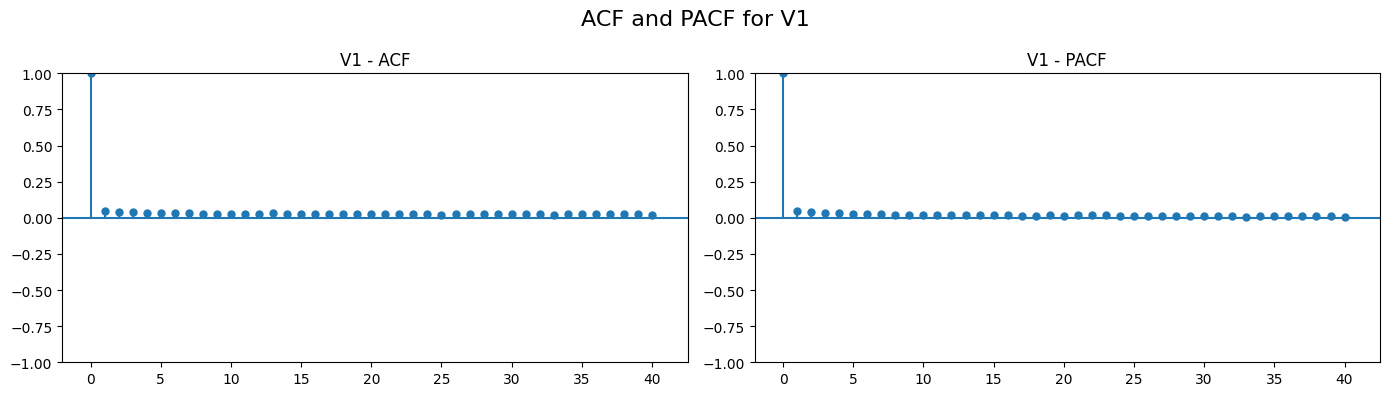

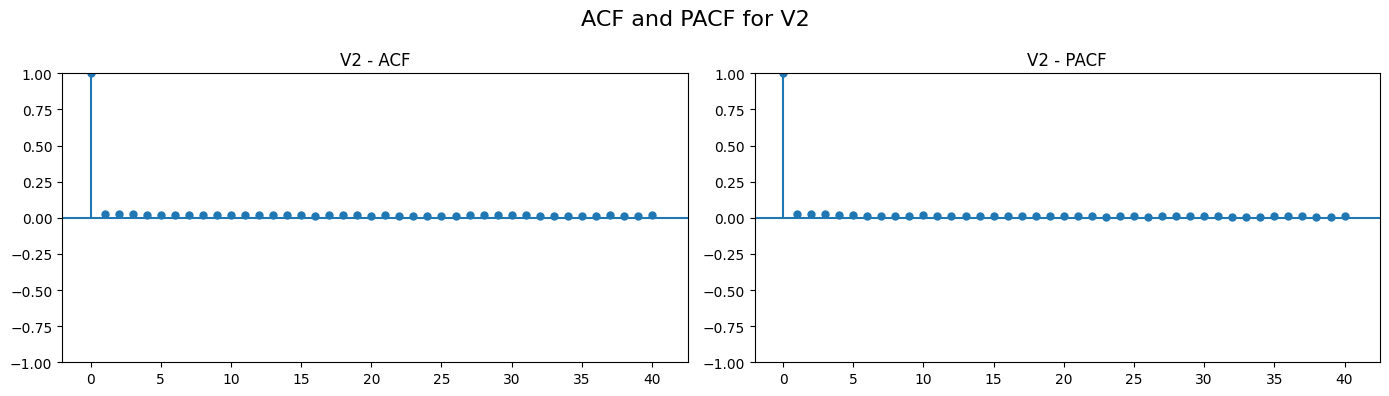

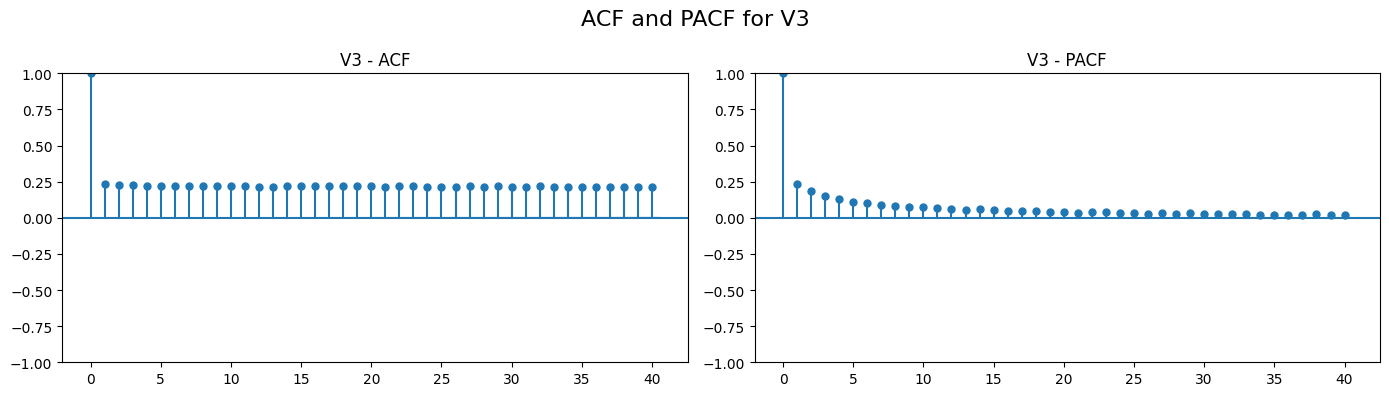

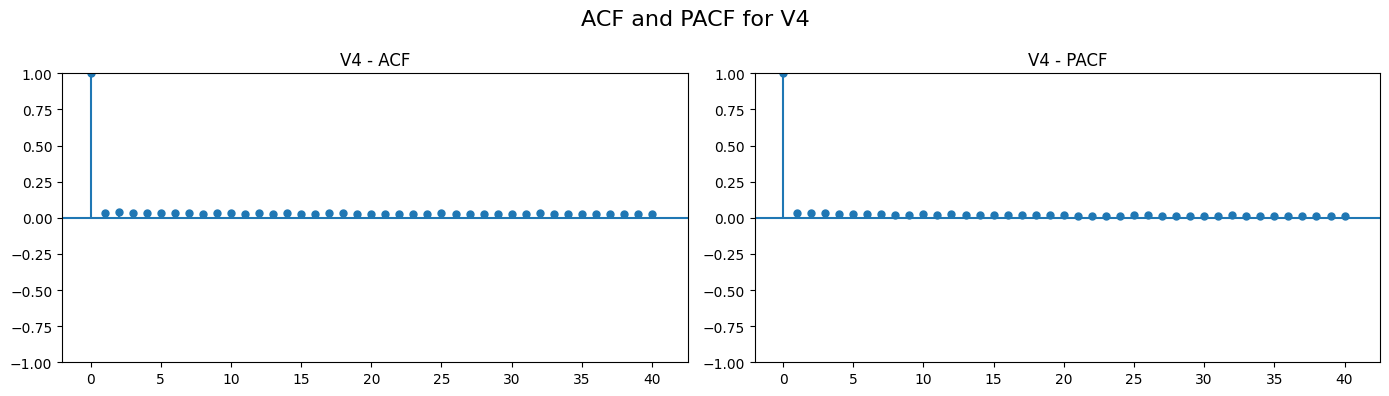

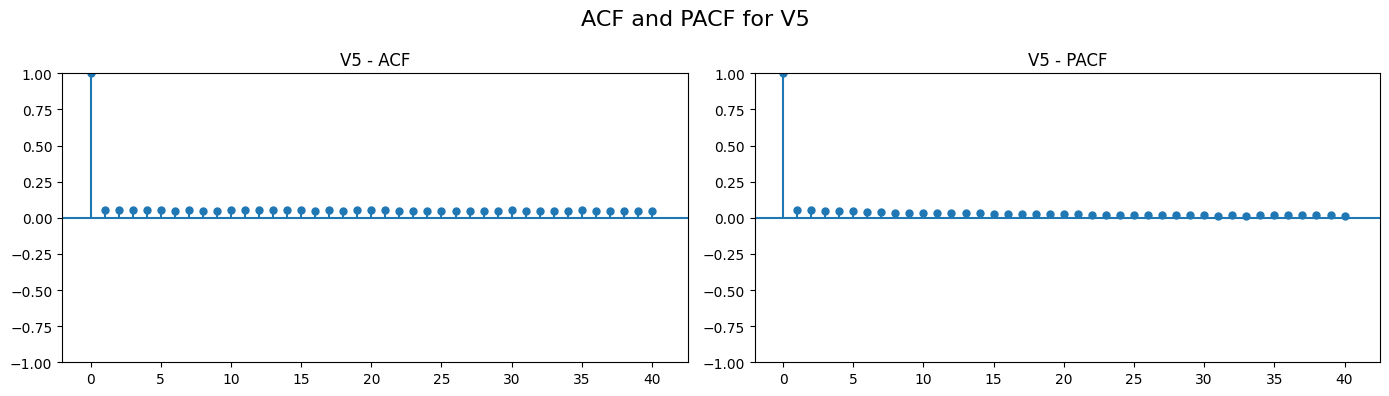

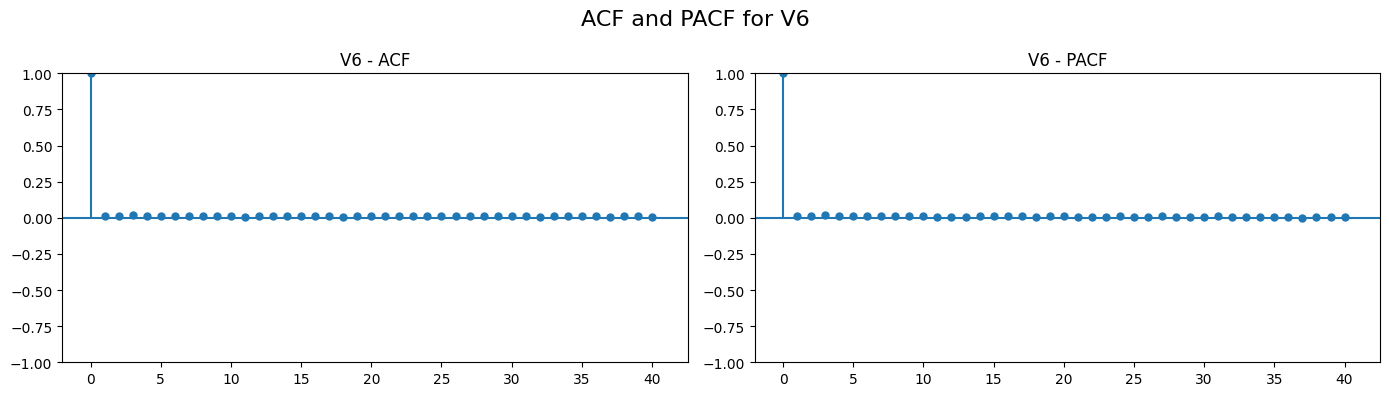

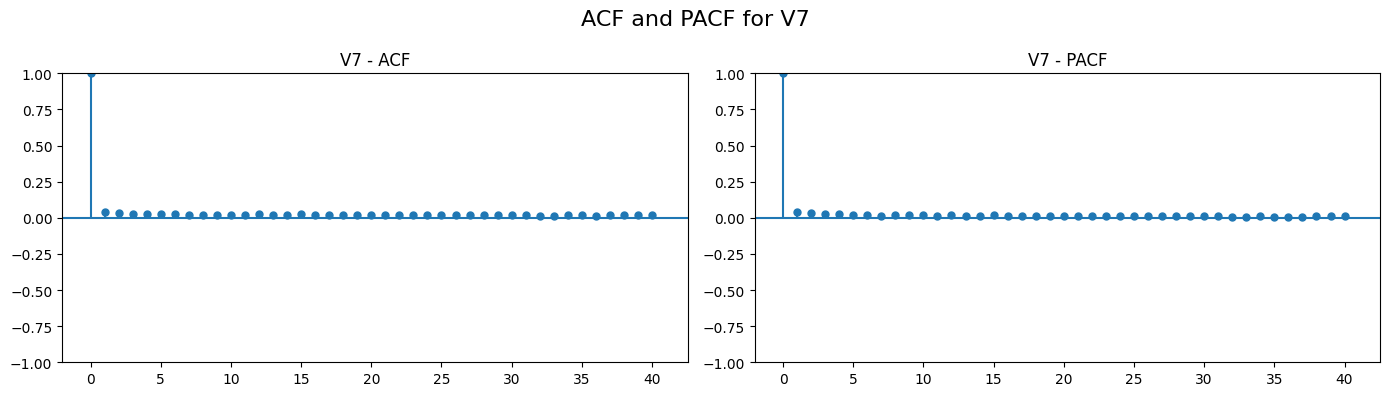

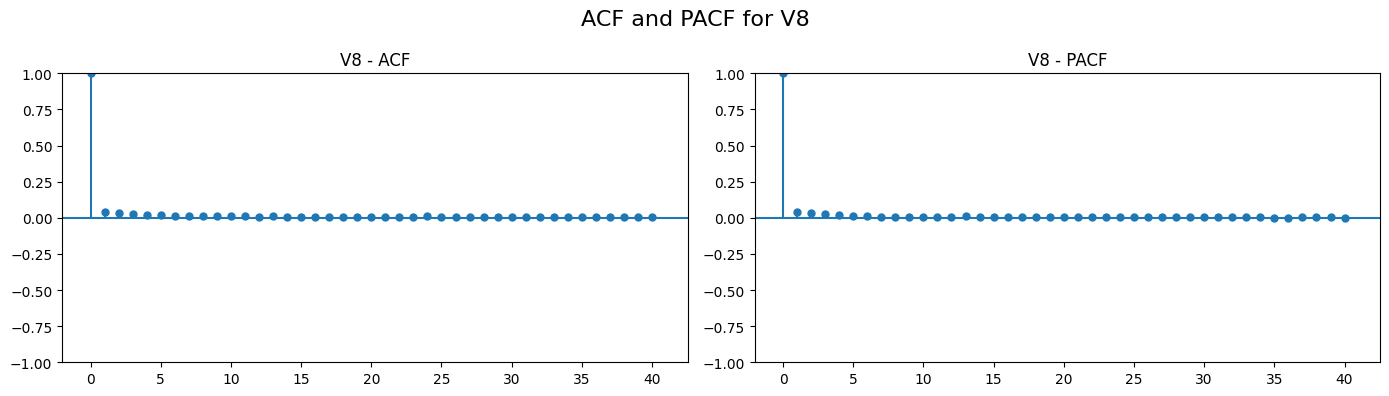

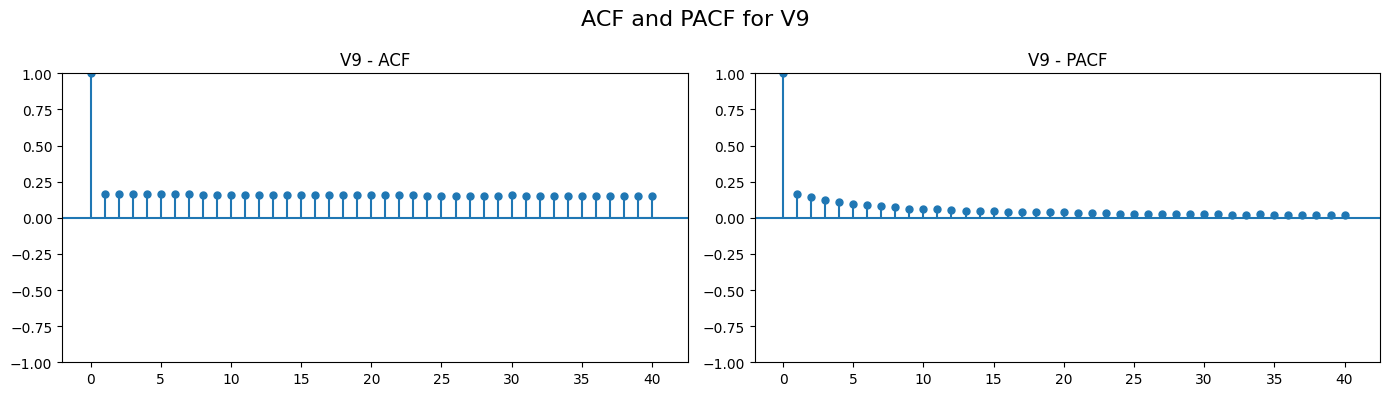

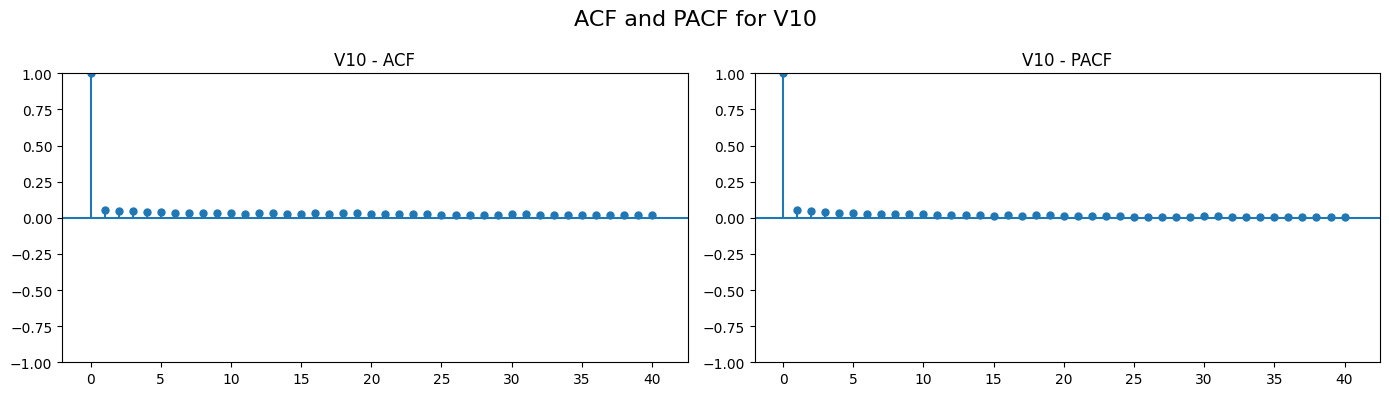

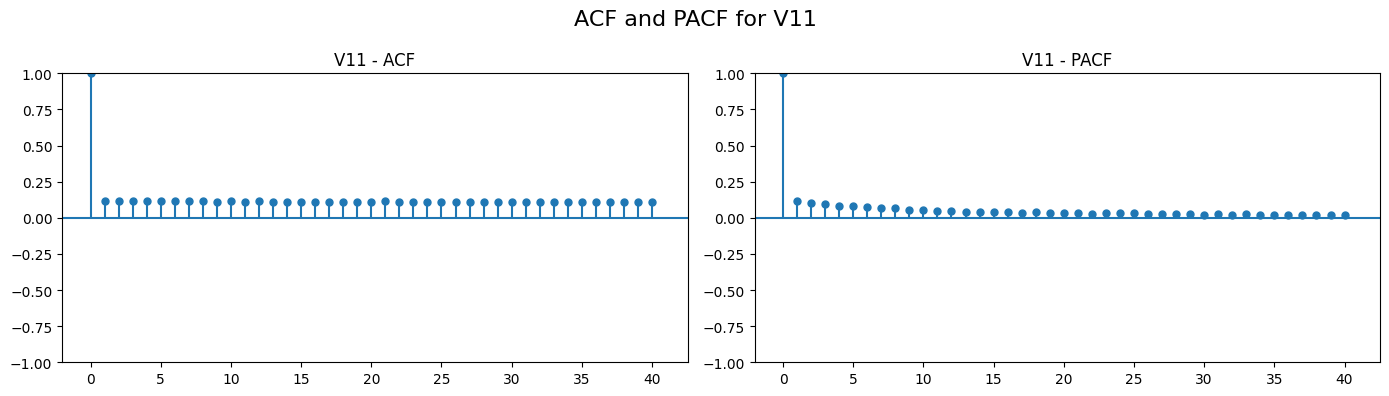

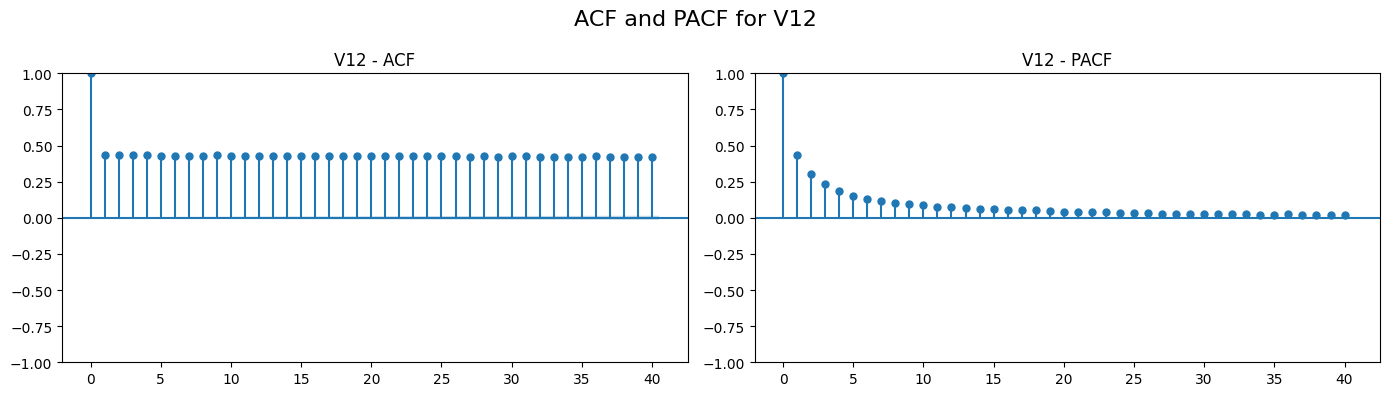

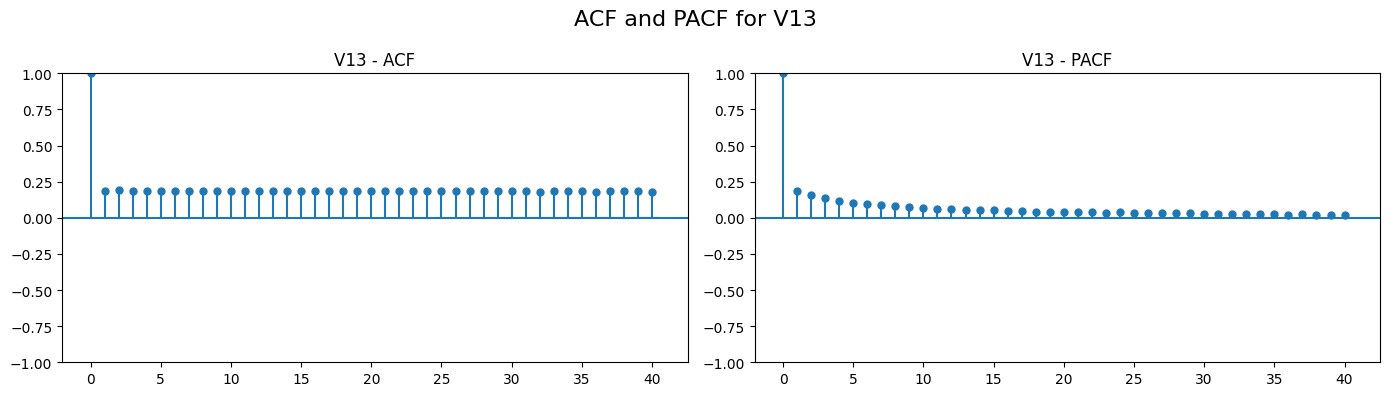

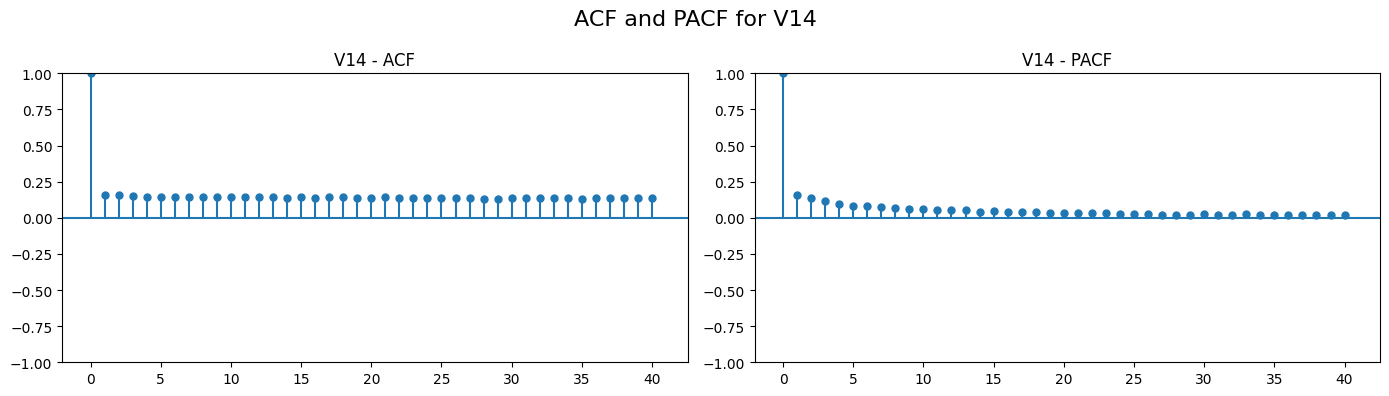

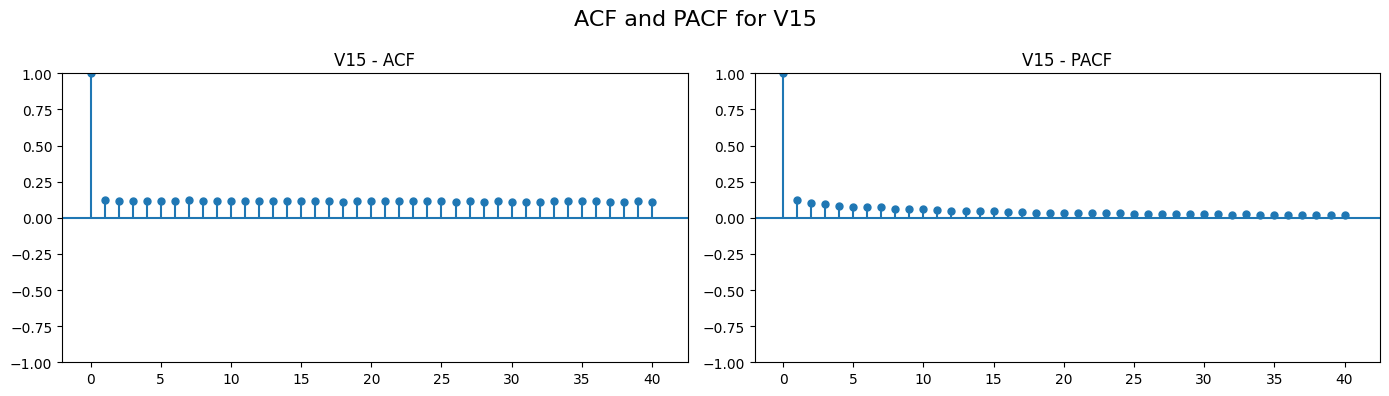

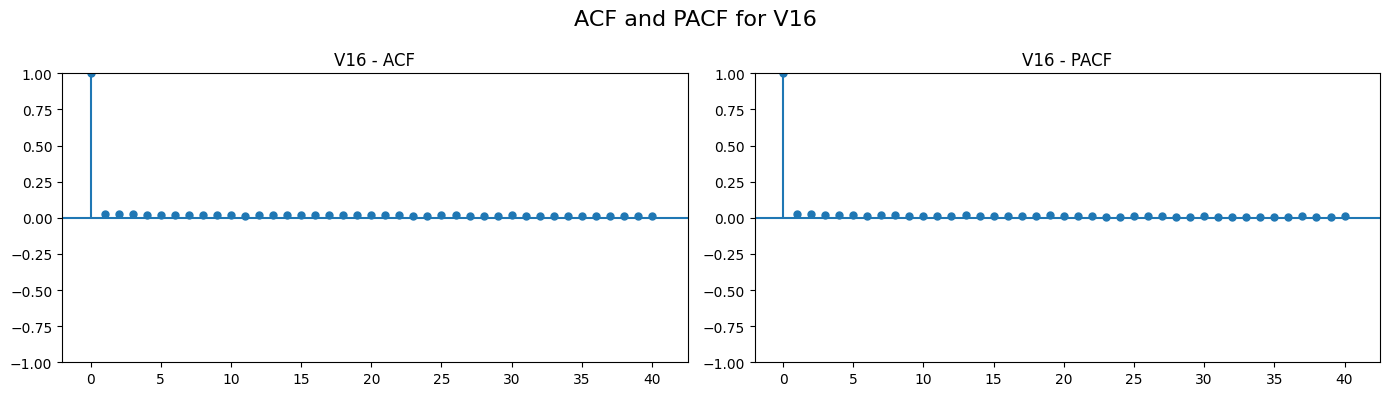

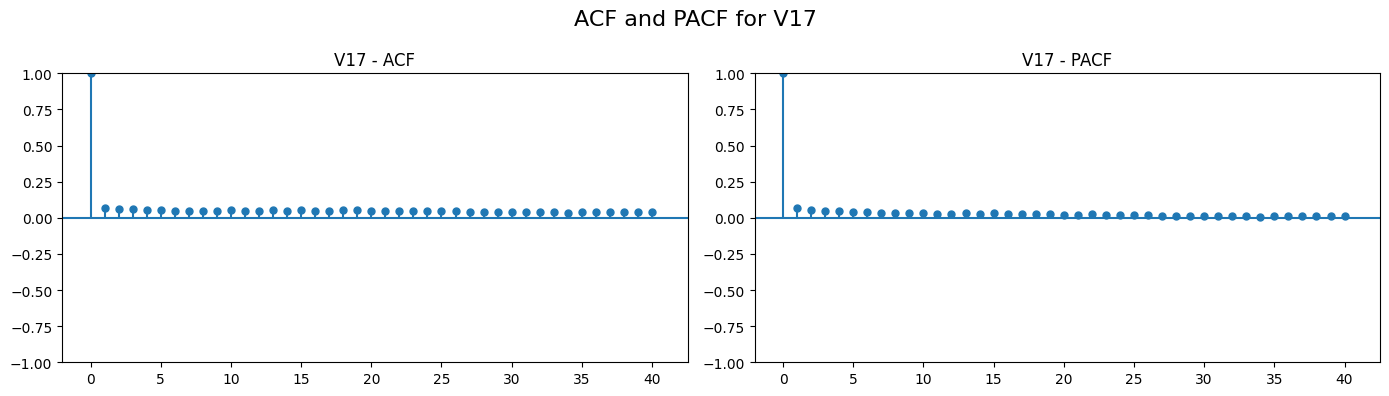

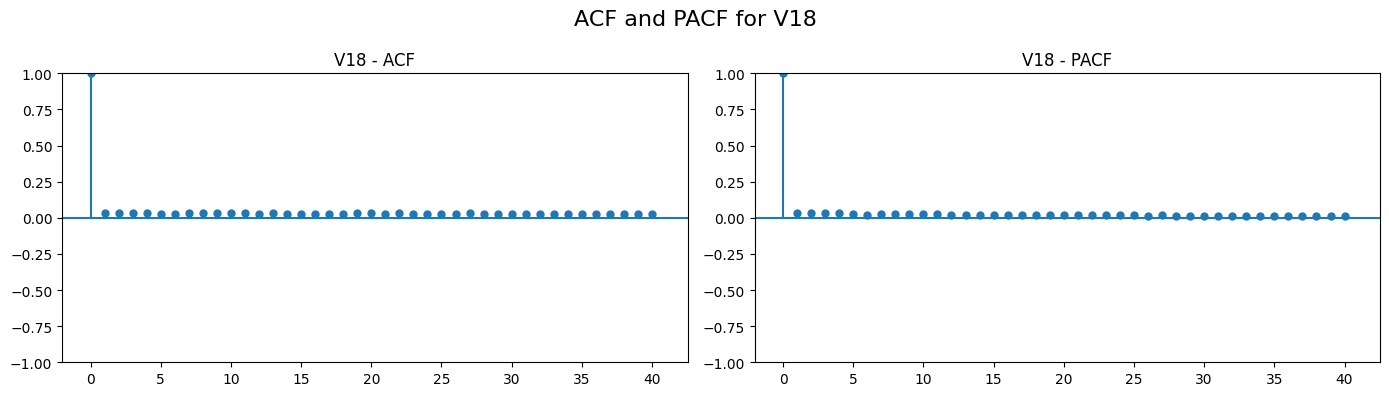

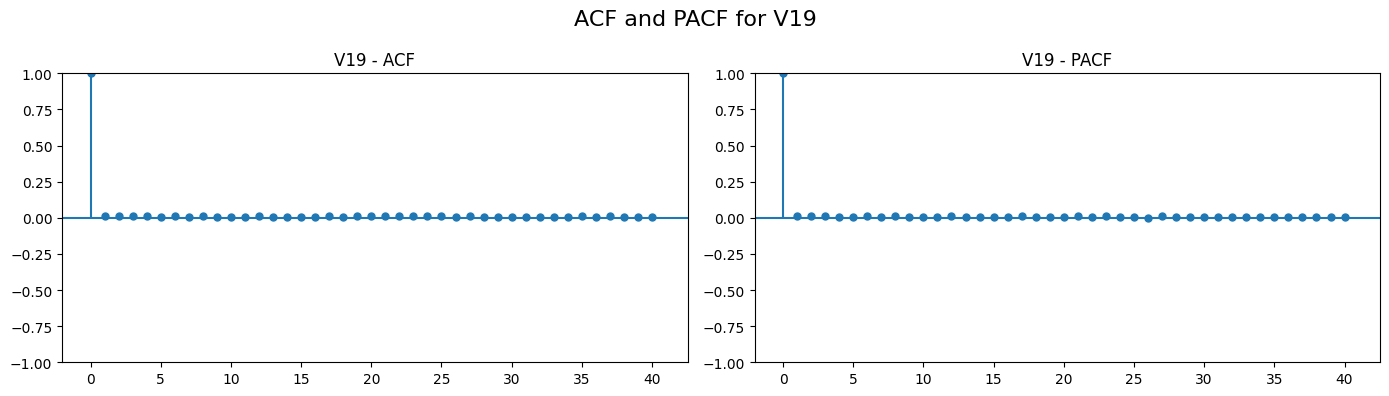

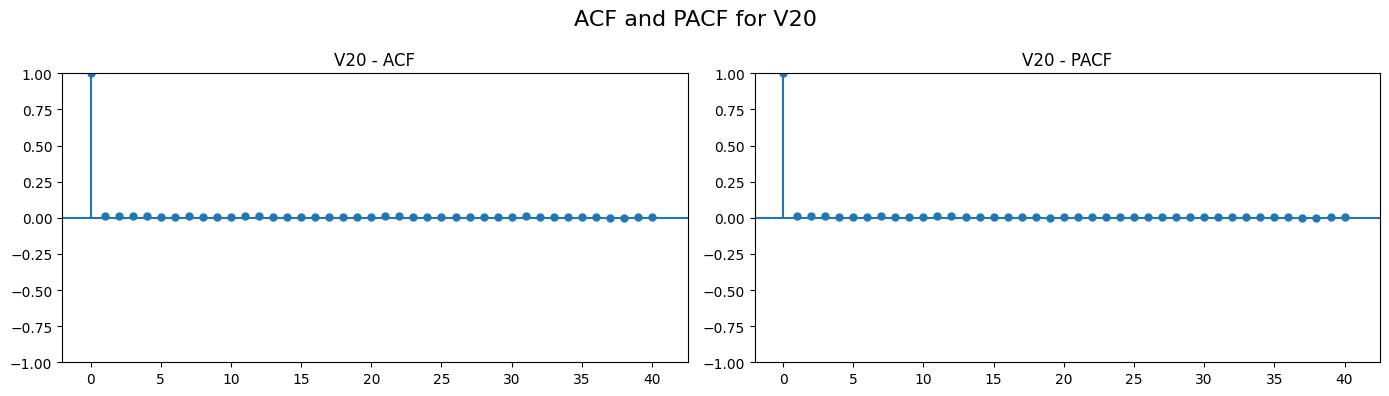

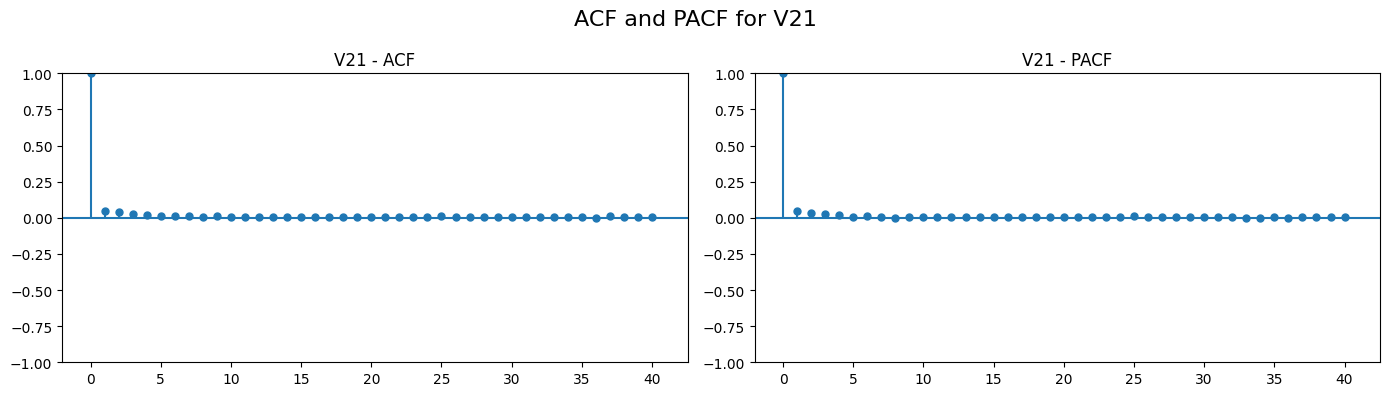

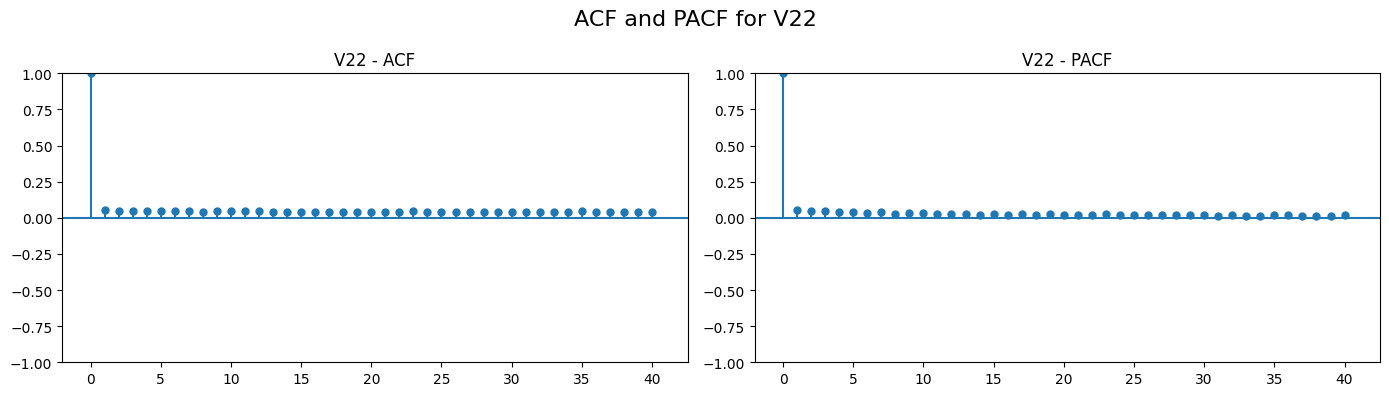

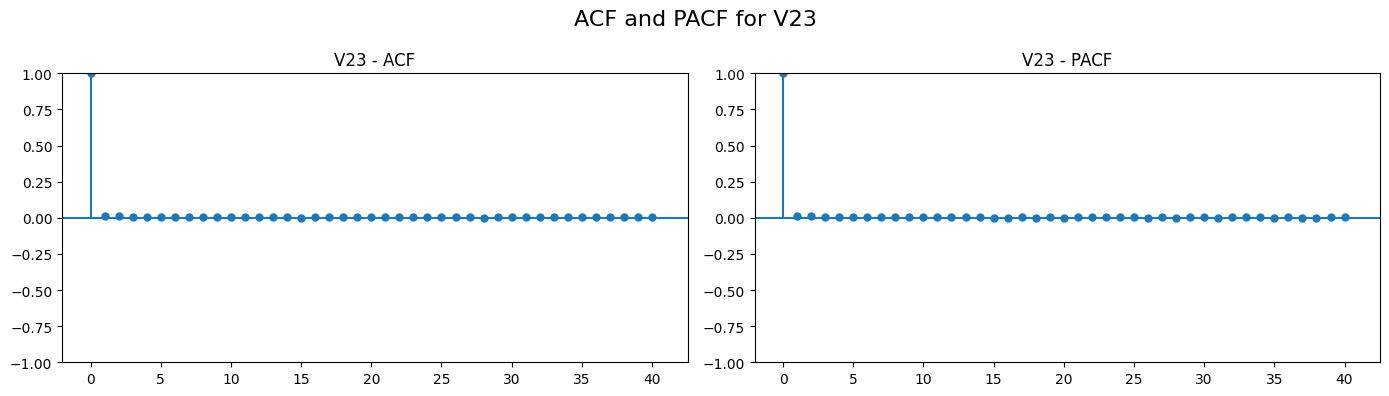

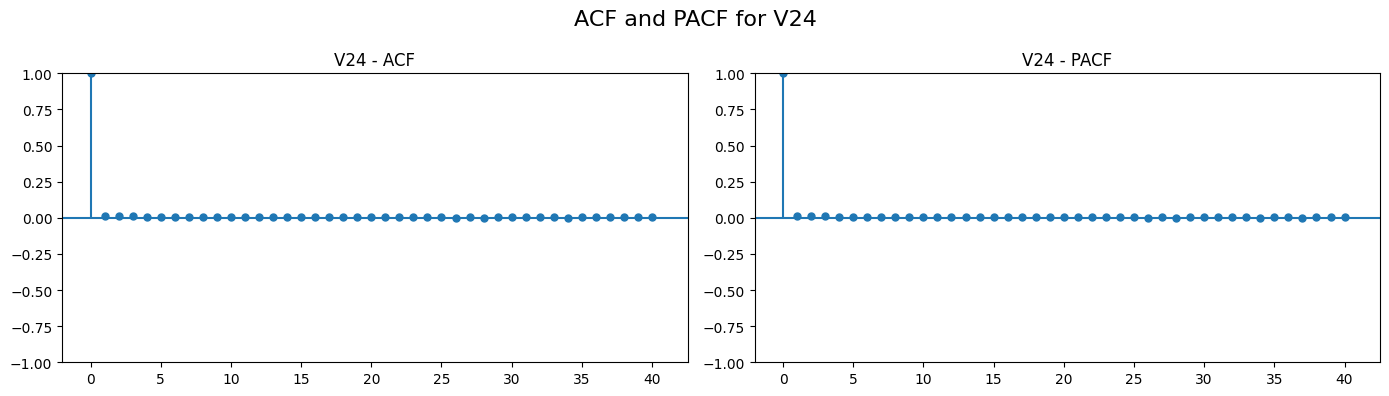

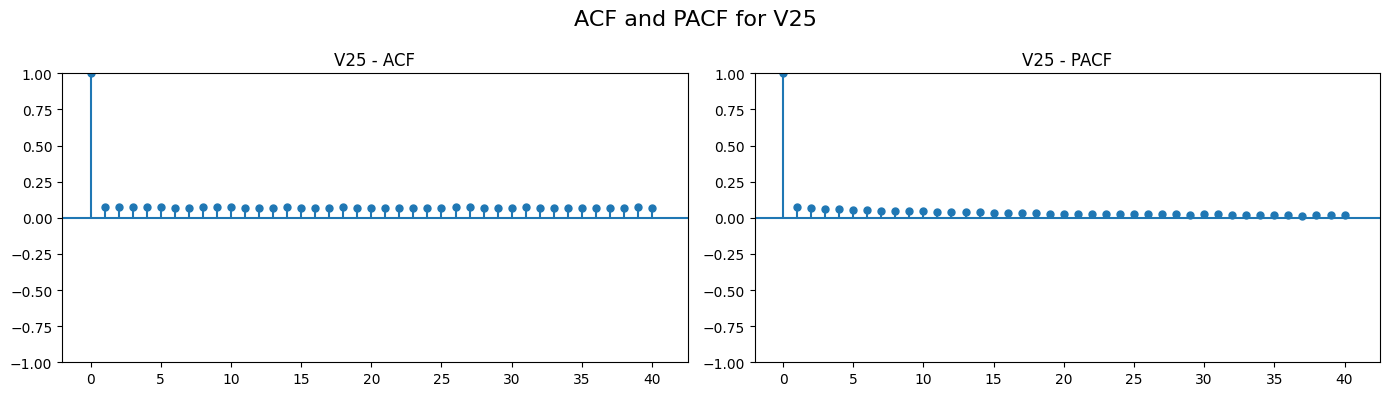

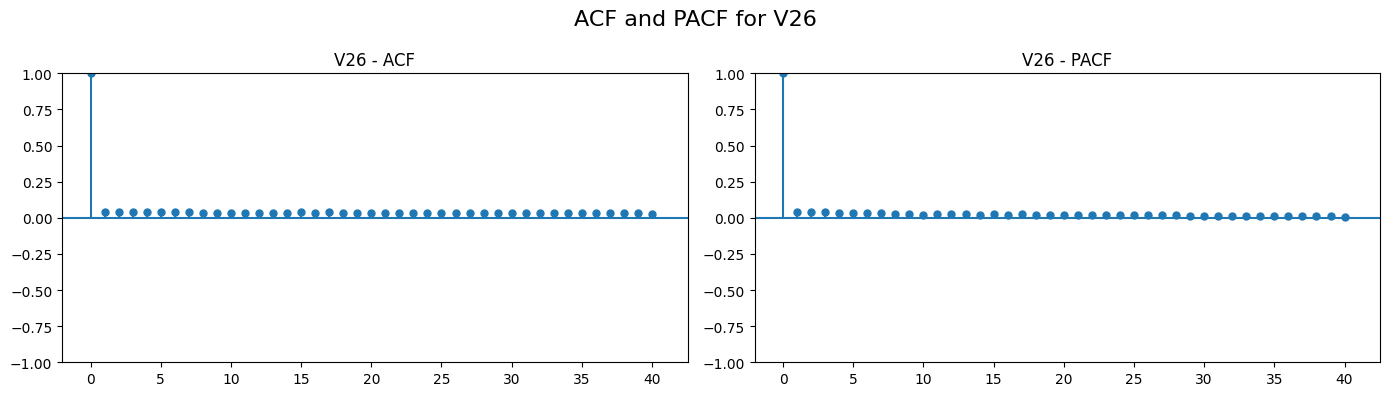

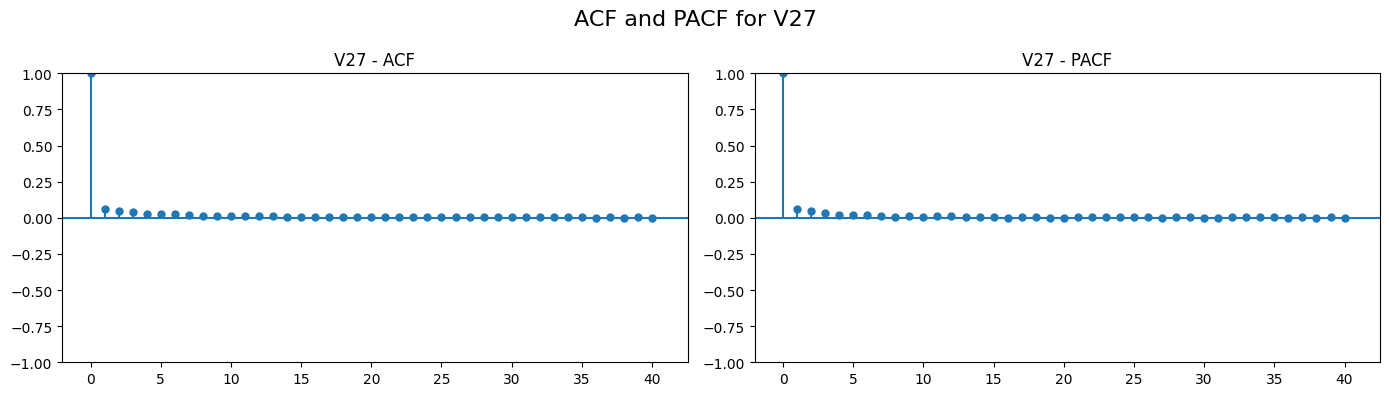

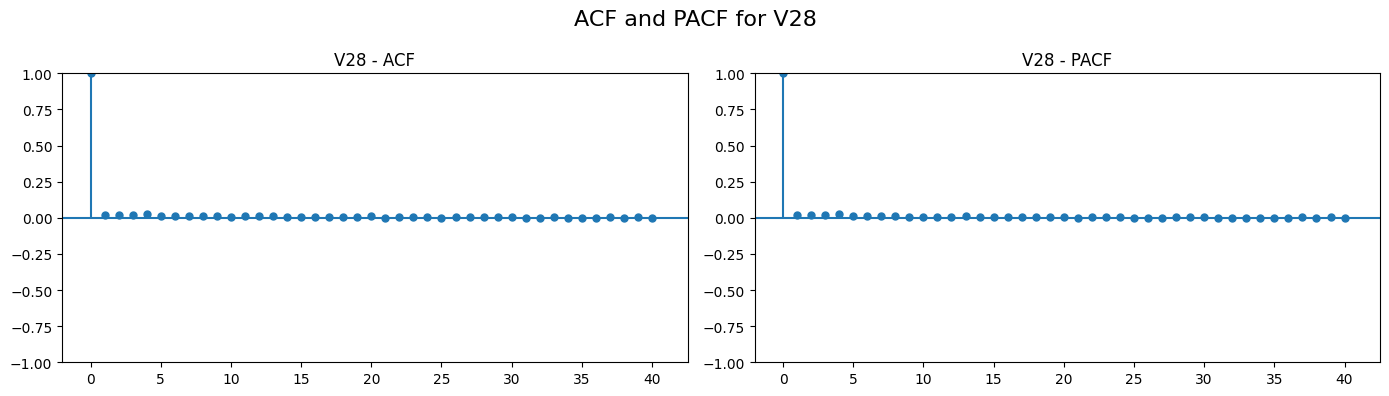

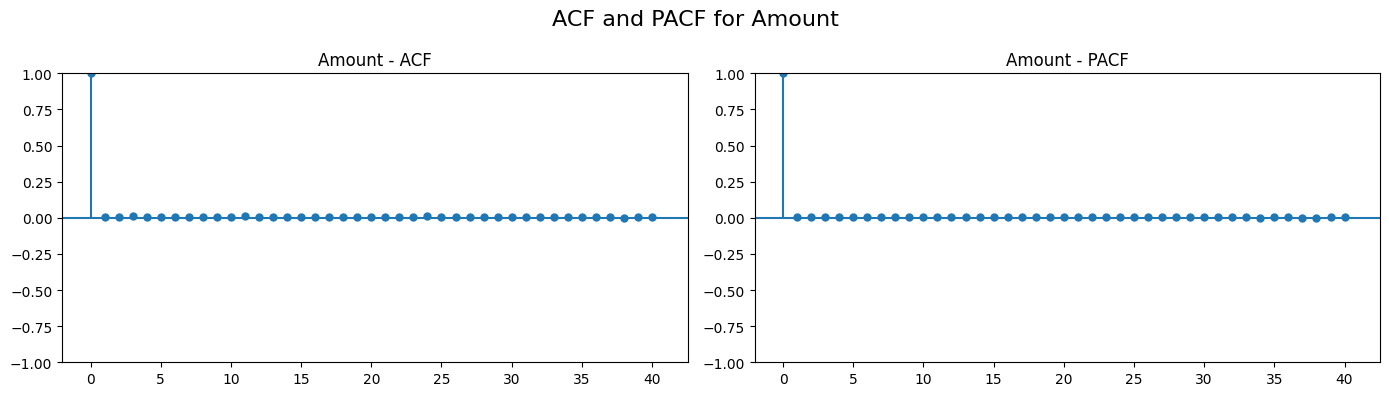

In [ ]:
plot_acf_pacf_all(df)

In [ ]:
#Feature scaling
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

#Define features and target
X = df.drop('Class', axis=1)
y = df['Class']

#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

In [7]:
#Function to train, predict, and evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Train, predict and evaluate a model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    #Model evaluation
    print(f"\nEvaluating {model.__class__.__name__}:")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    cm_display.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob)}")

    #Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

#List of models to evaluate
models = [
    XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    LogisticRegression(max_iter=1000, random_state=42),
    lgb.LGBMClassifier(n_estimators=200, random_state=42),
    #RandomForestClassifier(n_estimators=200, random_state=42)
]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.96      0.71      0.82        75

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.91     56962
weighted avg       1.00      1.00      1.00     56962



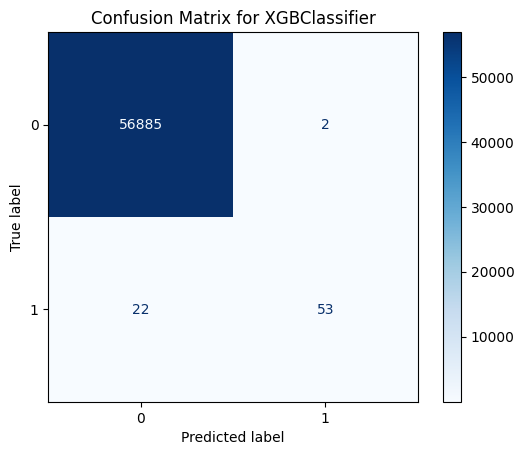

ROC AUC Score: 0.980130434018317

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.89      0.56      0.69        75

    accuracy                           1.00     56962
   macro avg       0.95      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962



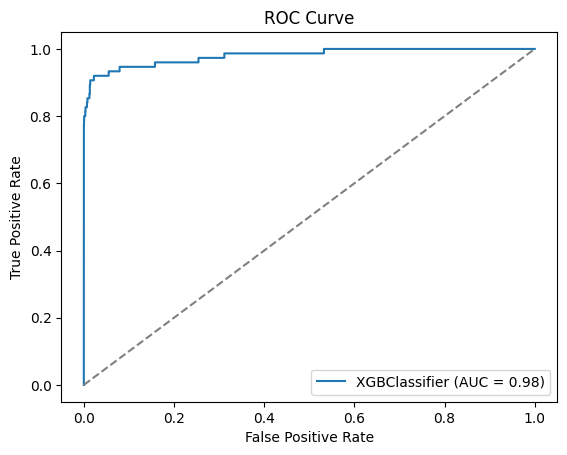

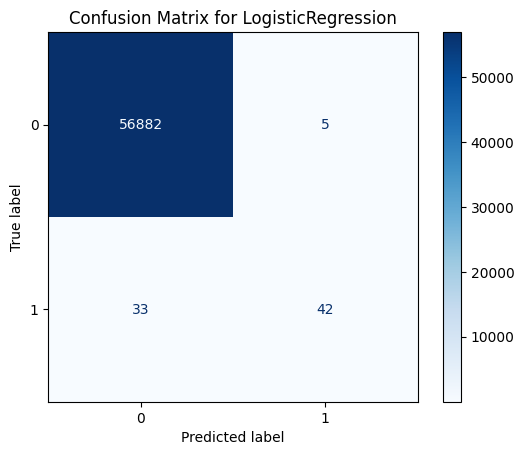

ROC AUC Score: 0.9777512143957905
[LightGBM] [Info] Number of positive: 417, number of negative: 227428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301503
[LightGBM] [Info] Start training from score -6.301503

Evaluating LGBMClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.95      0.28      0.43        75

    accuracy                           1.00     56962
   macro avg       0.98      0.64      0.72     56962
weighted avg       1.00      1.00      1.00     56962



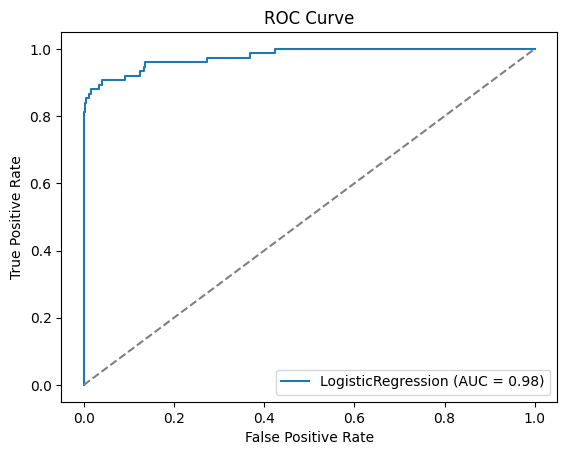

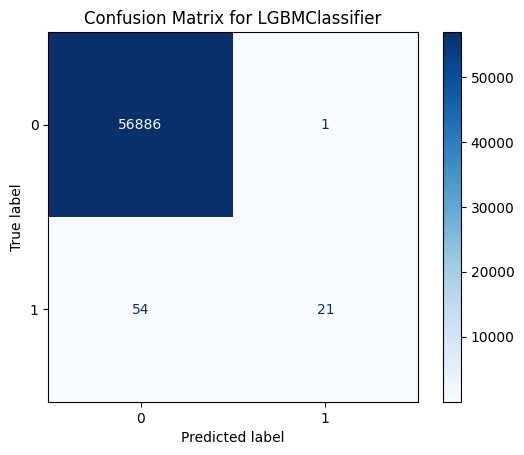

ROC AUC Score: 0.6599846479277632

Evaluating RandomForestClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.98      0.68      0.80        75

    accuracy                           1.00     56962
   macro avg       0.99      0.84      0.90     56962
weighted avg       1.00      1.00      1.00     56962



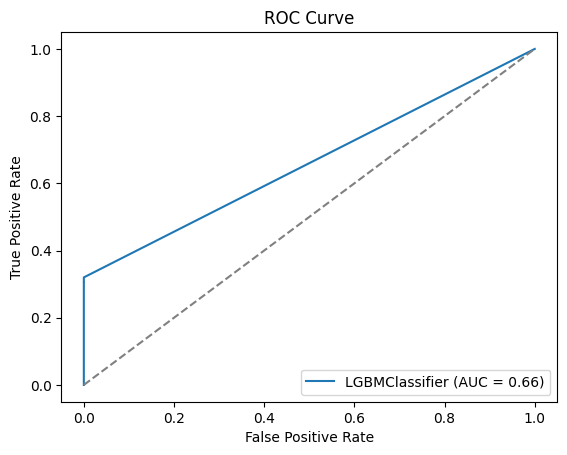

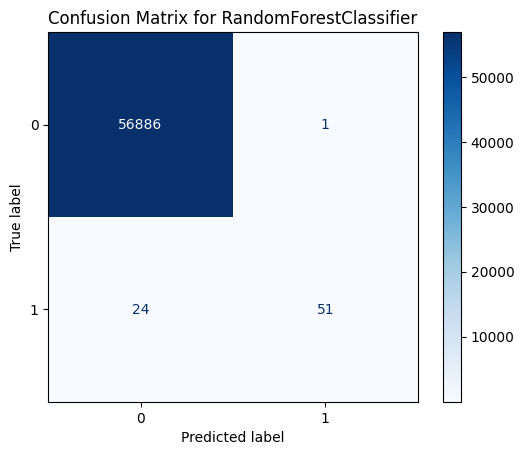

ROC AUC Score: 0.949384335026749


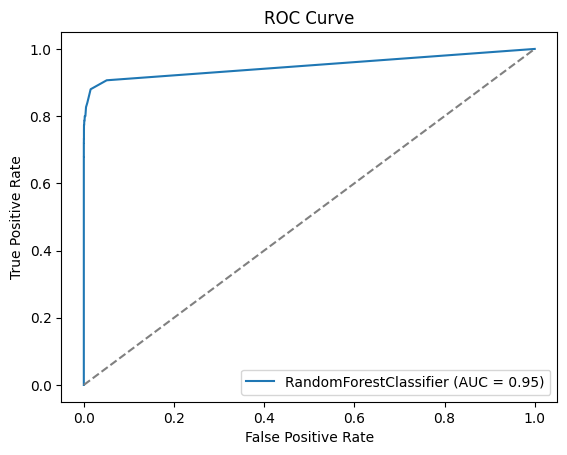

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()


Adding lag features to specific features.

In [ ]:
# def add_custom_lags(df, lag_config):
#     df_copy = df.copy()

#     for col, num_lags in lag_config.items():
#         for lag in range(1, num_lags + 1):
#             df_copy[f"{col}_lag{lag}"] = df_copy[col].shift(lag)

#     return df_copy

# lag_config = {
#     'V3': 3,
#     'V9': 2,
#     'V11': 1,
#     'V12': 3,
#     'V13': 3
# }


In [ ]:
def add_custom_lags_ver2(df, lag_config, y_col='Class', substitute_value=-999):

    df_copy = df.copy()

    #Create lag features
    for col, num_lags in lag_config.items():
        for lag in range(1, num_lags + 1):
            df_copy[f"{col}_lag{lag}"] = df_copy[col].shift(lag)

    #Identify all lag columns
    lag_cols = [f"{col}_lag{lag}" for col, n in lag_config.items() for lag in range(1, n + 1)]

    #Split into positive and negative classes
    positives = df_copy[df_copy[y_col] == 1].copy()
    negatives = df_copy[df_copy[y_col] == 0].copy()

    #Fill nulls in positive class
    positives[lag_cols] = positives[lag_cols].fillna(substitute_value)

    #Drop rows with any NaN in negative class
    negatives = negatives.dropna(subset=lag_cols)

    #Combine back
    df_final = pd.concat([positives, negatives]).sort_index()

    return df_final

lag_config = {
    'V3': 3,
    'V9': 2,
    'V11': 1,
    'V12': 3,
    'V13': 3
}




In [ ]:
df_with_lag_features = add_custom_lags_ver2(df, lag_config)

In [ ]:
df_with_lag_features.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'V3_lag1', 'V3_lag2', 'V3_lag3', 'V9_lag1', 'V9_lag2',
       'V11_lag1', 'V12_lag1', 'V12_lag2', 'V12_lag3', 'V13_lag1', 'V13_lag2',
       'V13_lag3'],
      dtype='object')

In [ ]:
#Feature scaling
scaler = StandardScaler()
df_with_lag_features['Amount'] = scaler.fit_transform(df_with_lag_features['Amount'].values.reshape(-1, 1))
df_with_lag_features['Time'] = scaler.fit_transform(df_with_lag_features['Time'].values.reshape(-1, 1))

#Define features and target
X = df_with_lag_features.drop('Class', axis=1)
y = df_with_lag_features['Class']

#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:43:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.98      0.73      0.84        75

    accuracy                           1.00     56961
   macro avg       0.99      0.87      0.92     56961
weighted avg       1.00      1.00      1.00     56961



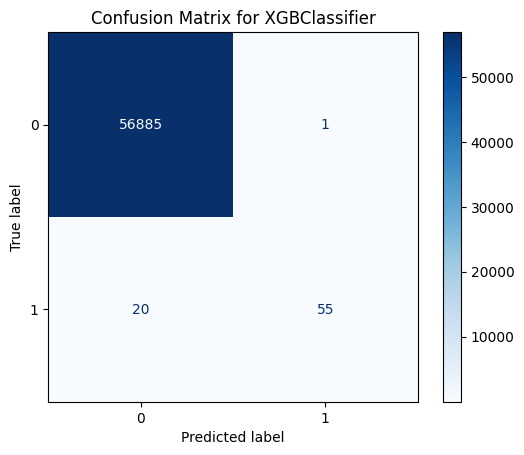

ROC AUC Score: 0.984044111615043

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.88      0.57      0.69        75

    accuracy                           1.00     56961
   macro avg       0.94      0.79      0.85     56961
weighted avg       1.00      1.00      1.00     56961



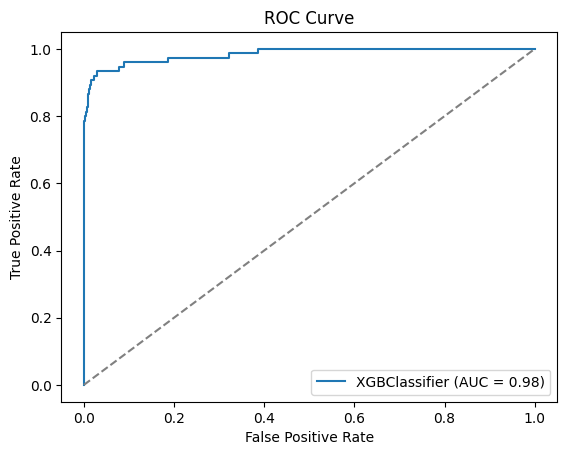

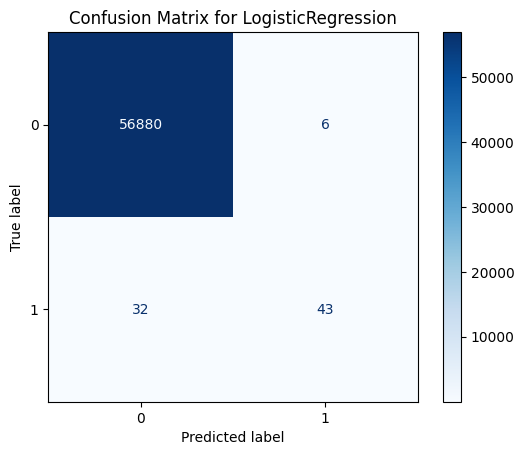

ROC AUC Score: 0.9817522764827902
[LightGBM] [Info] Number of positive: 417, number of negative: 227426
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 227843, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301494
[LightGBM] [Info] Start training from score -6.301494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

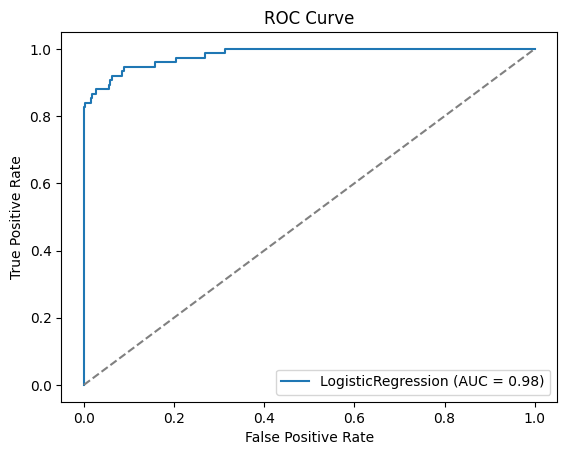

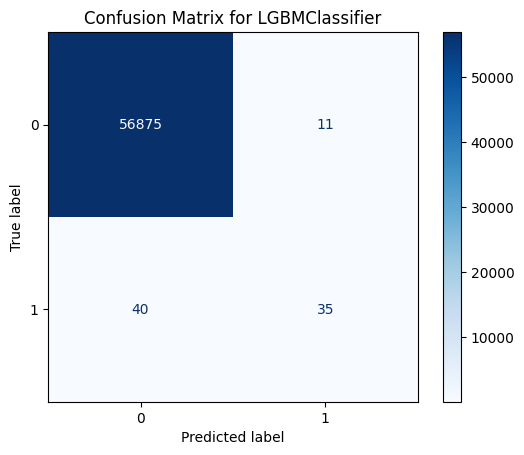

ROC AUC Score: 0.739870032462586


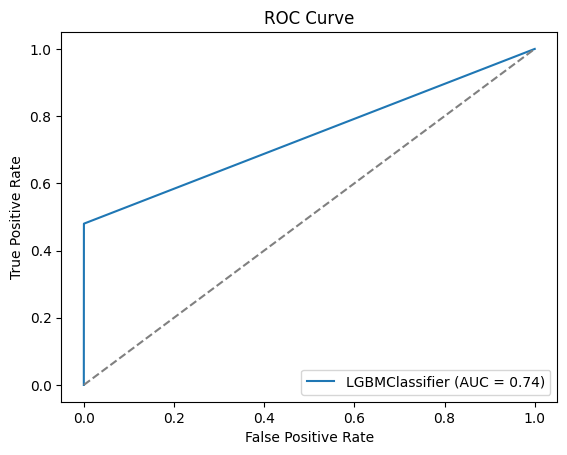

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()

# Adding minute and hour features
Minute and hour features are considered for the potential capturing of temporal patterns.

In [ ]:
print(df)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

In [ ]:
#Convert to hour (range is 0–23)
df['Hour'] = (df['Time'] // 3600) % 24

#Convert to minute of that hour
df['Minute'] = (df['Time'] // 60) % 60

These features are an attempt to capture how users act at a specific time of day. E.g, transactions occurring during specific hours or minutes may show certain patterns or risks, which can improve the model’s ability to detect underlying trends.



In [ ]:
#Scaling values
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['Hour'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Minute'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [ ]:
#Define features and target
X = df.drop('Class', axis=1)
y = df['Class']

#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

### Without lag features

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.96      0.71      0.82        75

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.91     56962
weighted avg       1.00      1.00      1.00     56962



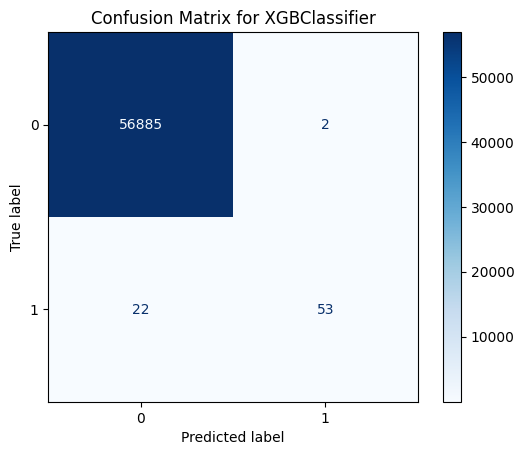

ROC AUC Score: 0.980130434018317

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.91      0.55      0.68        75

    accuracy                           1.00     56962
   macro avg       0.96      0.77      0.84     56962
weighted avg       1.00      1.00      1.00     56962



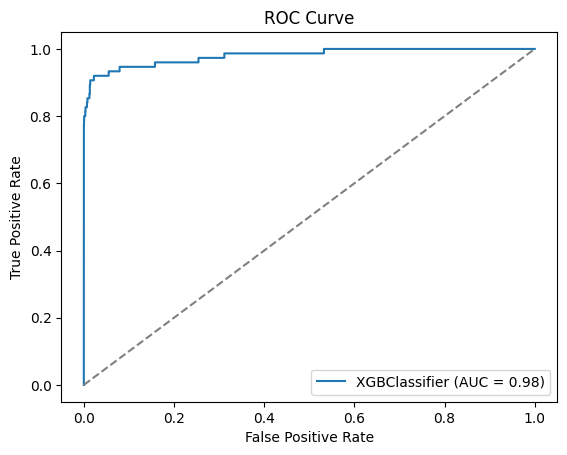

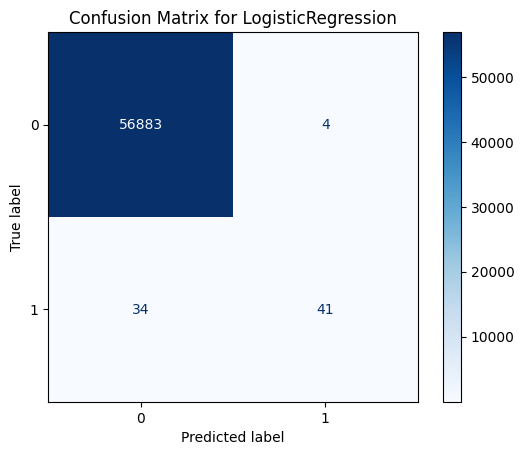

ROC AUC Score: 0.9781545871640269
[LightGBM] [Info] Number of positive: 417, number of negative: 227428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301503
[LightGBM] [Info] Start training from score -6.301503

Evaluating LGBMClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.95      0.28      0.43        75

    accuracy                           1.00     56962
   macro avg       0.98      0.64      0.72     56962
weighted avg       1.00      1.00      1.00     56962



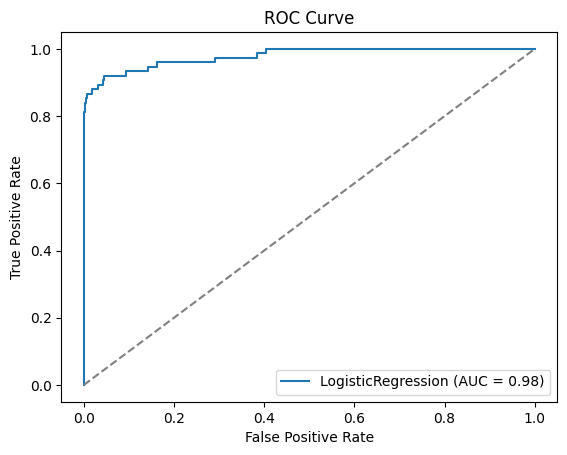

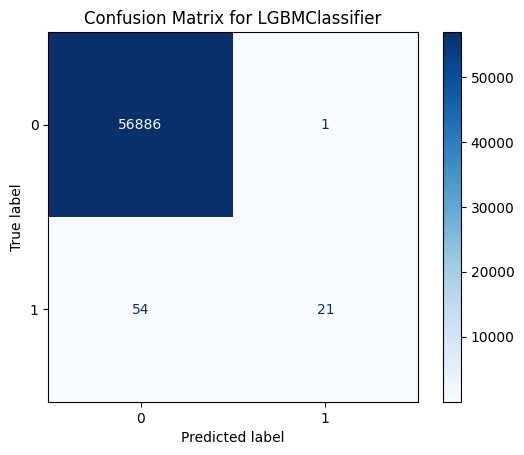

ROC AUC Score: 0.6599846479277632


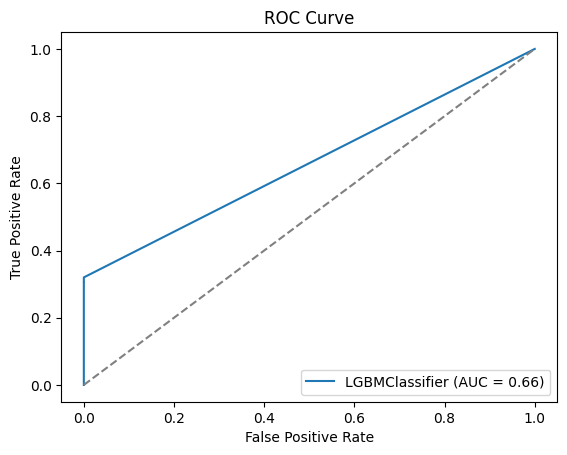

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()

### With lag features

In [ ]:
df_with_lag_features = add_custom_lags_ver2(df, lag_config)

In [ ]:
#Define features and target
X = df_with_lag_features.drop('Class', axis=1)
y = df_with_lag_features['Class']

#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:02:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.98      0.73      0.84        75

    accuracy                           1.00     56961
   macro avg       0.99      0.87      0.92     56961
weighted avg       1.00      1.00      1.00     56961



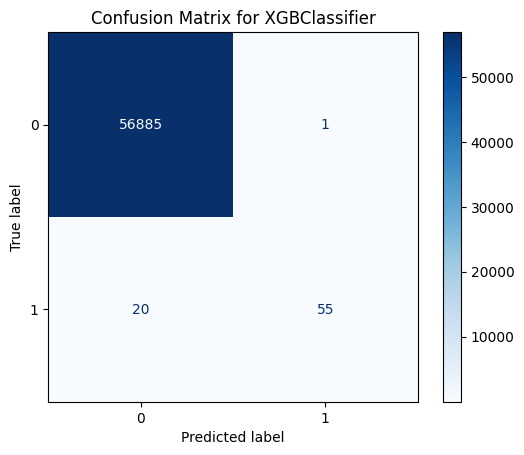

ROC AUC Score: 0.984044111615043

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.95      0.56      0.71        75

    accuracy                           1.00     56961
   macro avg       0.98      0.78      0.85     56961
weighted avg       1.00      1.00      1.00     56961



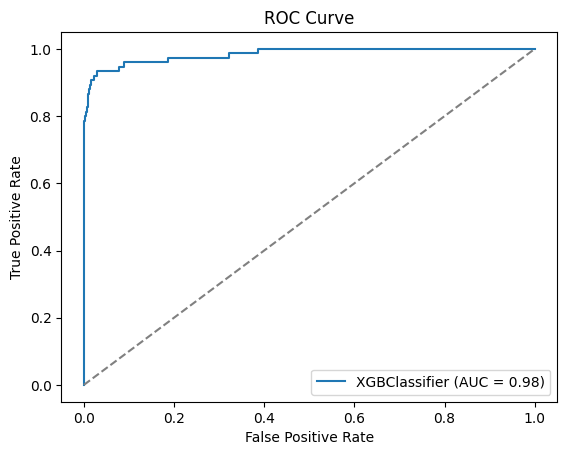

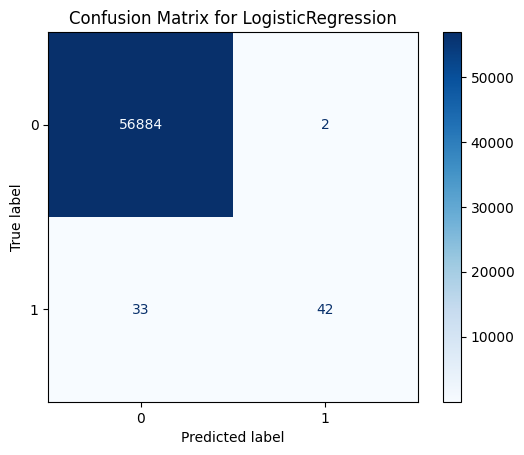

ROC AUC Score: 0.9815235148659893
[LightGBM] [Info] Number of positive: 417, number of negative: 227426
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 227843, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301494
[LightGBM] [Info] Start training from score -6.301494

Evaluating LGBMClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.09      0.29      0.14        75

    accuracy                           1.00     56961
   macro avg       0.54      0.64      0.57     56961
weighted avg       1.00      1.00      1.00     56961



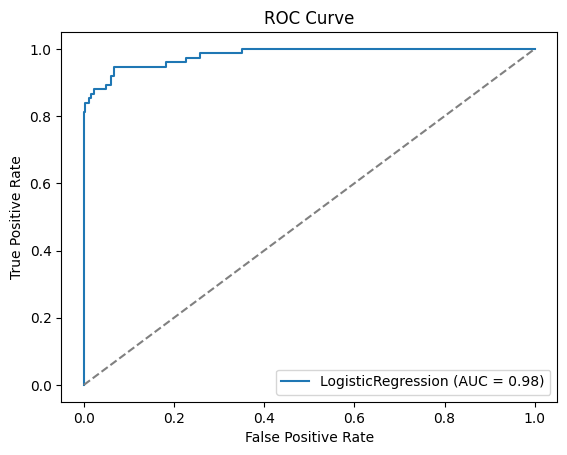

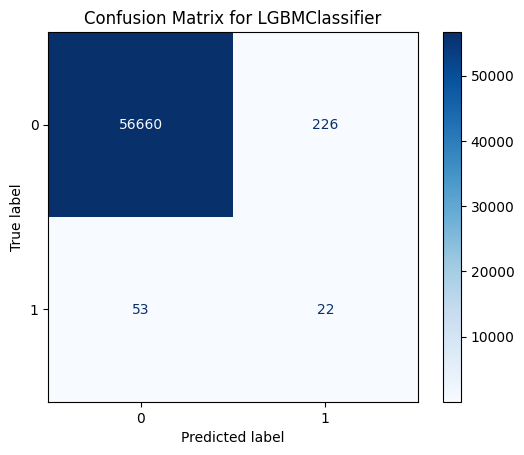

ROC AUC Score: 0.6443764722427311


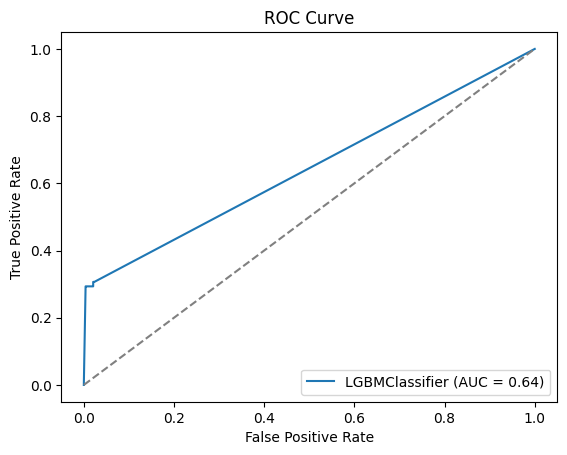

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()

# Rolling Window

Rolling window was experimented with to capture potential short-term trends over time. With credit card fraud, it may indicate abornalities in transaction amounts which may correlate with fraud cases.

A window size of 3 steps was chosen because the dataset covers a relatively short time range.

In [ ]:
#Rolling mean over the past 3 time steps
df['Amount_rolling_mean_3'] = df['Amount'].rolling(window=3).mean()

#Rolling sum the past 3 time steps
df['Amount_rolling_sum_3'] = df['Amount'].rolling(window=3).sum()

#Rolling standard deviation over the past 3 time steps
df['Amount_rolling_std_3'] = df['Amount'].rolling(window=3).std()


In [ ]:
#Drop rows with NaNs caused by rolling
df.dropna(inplace=True)

In [ ]:
#Scaling values
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))


In [ ]:
df['Amount_rolling_mean_3'] = scaler.fit_transform(df['Amount_rolling_mean_3'].values.reshape(-1, 1))
df['Amount_rolling_sum_3'] = scaler.fit_transform(df['Amount_rolling_sum_3'].values.reshape(-1, 1))
df['Amount_rolling_std_3'] = scaler.fit_transform(df['Amount_rolling_std_3'].values.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:16:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.96      0.72      0.82        75

    accuracy                           1.00     56961
   macro avg       0.98      0.86      0.91     56961
weighted avg       1.00      1.00      1.00     56961



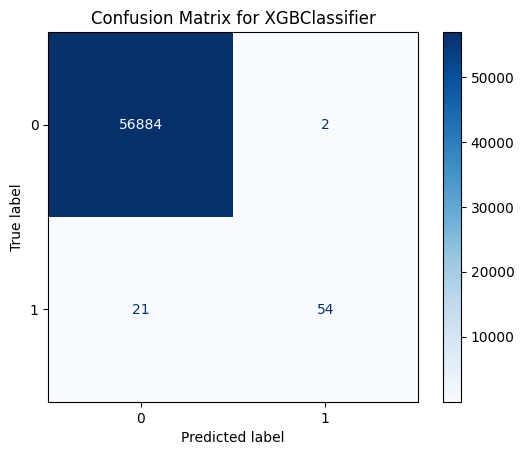

ROC AUC Score: 0.9845321051459645


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.97      0.47      0.63        75

    accuracy                           1.00     56961
   macro avg       0.99      0.73      0.82     56961
weighted avg       1.00      1.00      1.00     56961



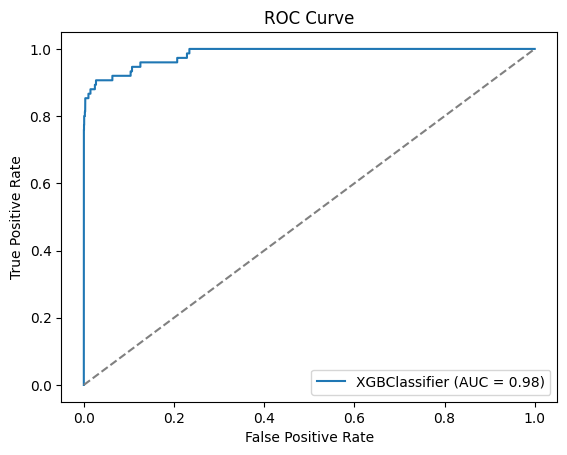

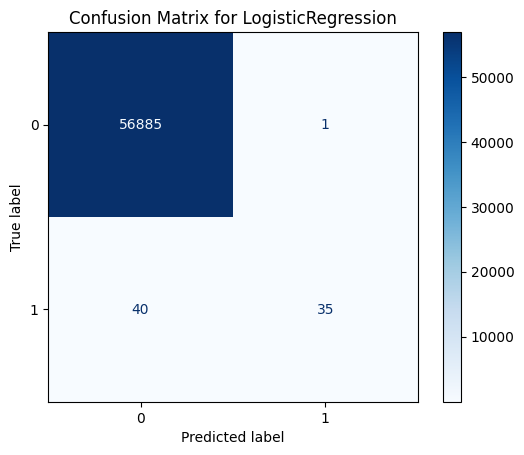

ROC AUC Score: 0.9456159101829391
[LightGBM] [Info] Number of positive: 417, number of negative: 227427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 227844, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301498
[LightGBM] [Info] Start training from score -6.301498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

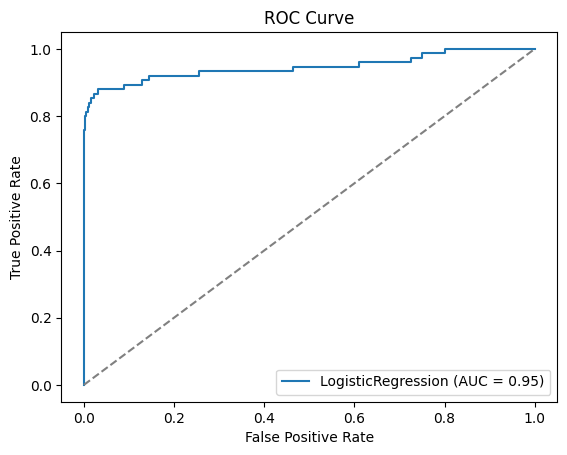

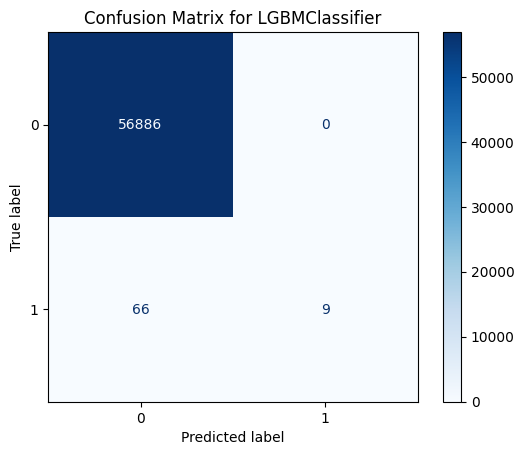

ROC AUC Score: 0.58


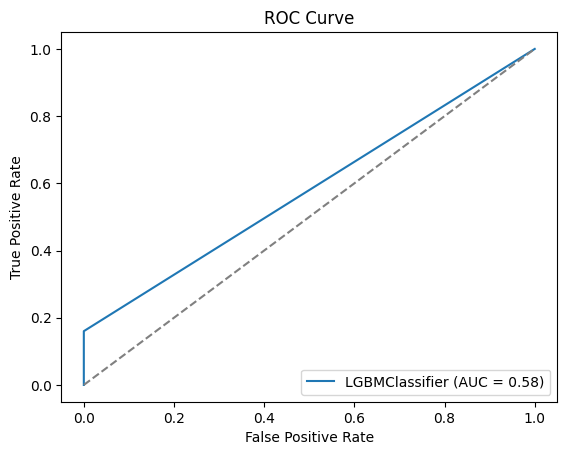

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()

From the metrics above, it can be seen that with the rolling window features alone, there is no increase in performance in comparison to the models that utilized the lag features.

# Combinations

Different combinations of features (lag, rolling window and temporal) will be utilized to see if it improves the performance of the models.

In [ ]:
df = df_backup.copy()

In [ ]:
scaler = StandardScaler()
df['Amount_rolling_mean_3'] = scaler.fit_transform(df['Amount_rolling_mean_3'].values.reshape(-1, 1))
df['Amount_rolling_sum_3'] = scaler.fit_transform(df['Amount_rolling_sum_3'].values.reshape(-1, 1))
df['Amount_rolling_std_3'] = scaler.fit_transform(df['Amount_rolling_std_3'].values.reshape(-1, 1))
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [ ]:
df_with_lag_features = add_custom_lags_ver2(df, lag_config)
X = df_with_lag_features.drop('Class', axis=1)
y = df_with_lag_features['Class']



In [ ]:
df_with_lag_features.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Amount_rolling_mean_3', 'Amount_rolling_sum_3',
       'Amount_rolling_std_3', 'V3_lag1', 'V3_lag2', 'V3_lag3', 'V9_lag1',
       'V9_lag2', 'V11_lag1', 'V12_lag1', 'V12_lag2', 'V12_lag3', 'V13_lag1',
       'V13_lag2', 'V13_lag3'],
      dtype='object')

In [ ]:
#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

### Lag Features + Rolling Window

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:56:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.98      0.72      0.83        75

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961



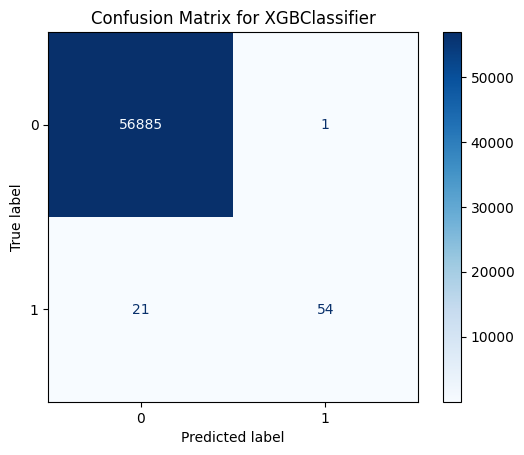

ROC AUC Score: 0.9760705035802599

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.89      0.55      0.68        75

    accuracy                           1.00     56961
   macro avg       0.95      0.77      0.84     56961
weighted avg       1.00      1.00      1.00     56961



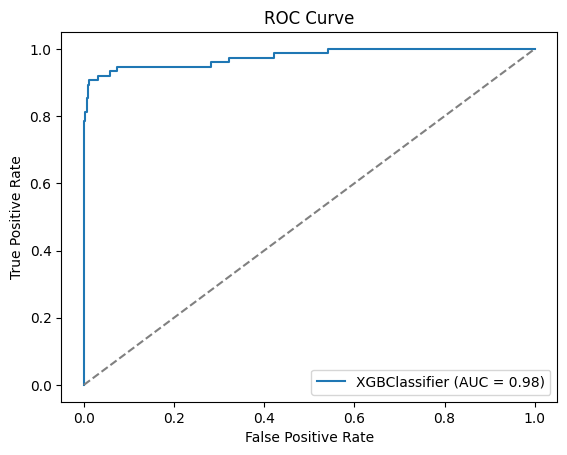

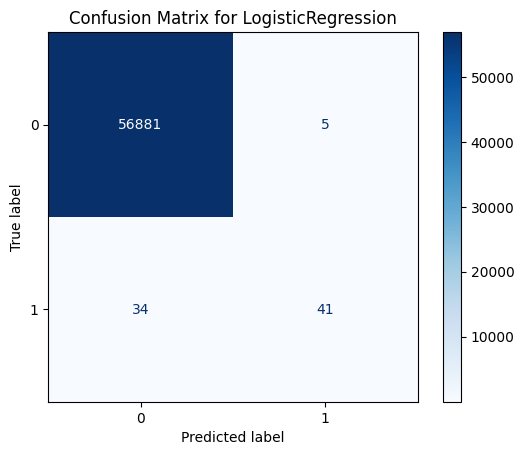

ROC AUC Score: 0.9809975506568692
[LightGBM] [Info] Number of positive: 417, number of negative: 227424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 227841, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301485
[LightGBM] [Info] Start training from score -6.301485

Evaluating LGBMClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.03      0.09      0.04        75

    accuracy                           0.99     56961
   macro avg       0.51      0.54      0.52     56961
weighted avg       1.00      0.99      1.00     56961



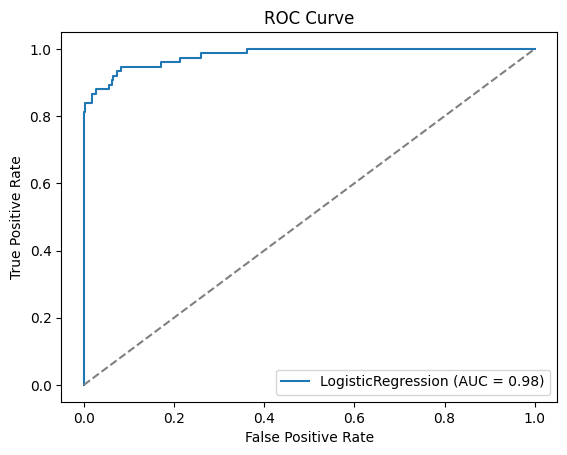

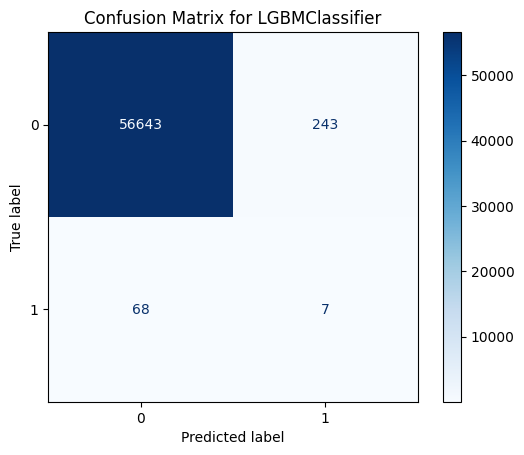

ROC AUC Score: 0.5436088551371749


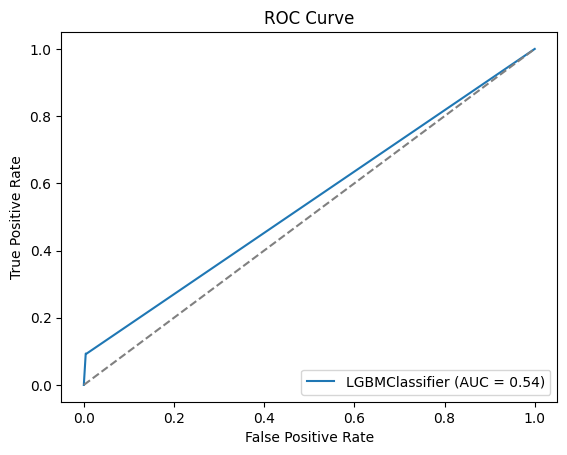

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()

From the metrics above, it can be seen that this combination is not fruitful in creating superior performing models.

Temporal, Rolling Window and Lag Feature Combination

In [ ]:
#Convert to hour (range is 0–23)
df_with_lag_features['Hour'] = (df_with_lag_features['Time'] // 3600) % 24

#Convert to minute of that hour
df_with_lag_features['Minute'] = (df_with_lag_features['Time'] // 60) % 60

In [ ]:
df_with_lag_features['Hour'] = scaler.fit_transform(df_with_lag_features['Amount'].values.reshape(-1, 1))
df_with_lag_features['Minute'] = scaler.fit_transform(df_with_lag_features['Time'].values.reshape(-1, 1))

In [ ]:
X = df_with_lag_features.drop('Class', axis=1)
y = df_with_lag_features['Class']

In [ ]:
#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:02:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating XGBClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.98      0.72      0.83        75

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961



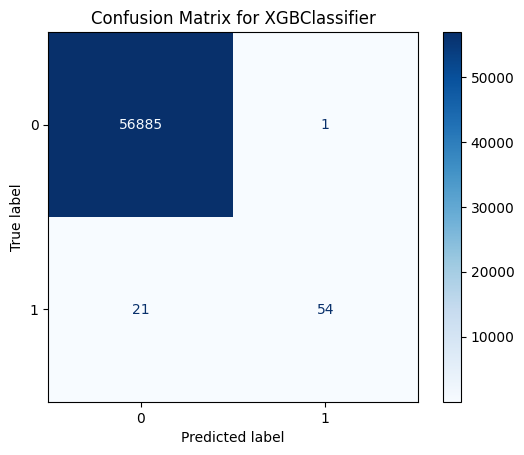

ROC AUC Score: 0.9760705035802599

Evaluating LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.91      0.57      0.70        75

    accuracy                           1.00     56961
   macro avg       0.96      0.79      0.85     56961
weighted avg       1.00      1.00      1.00     56961



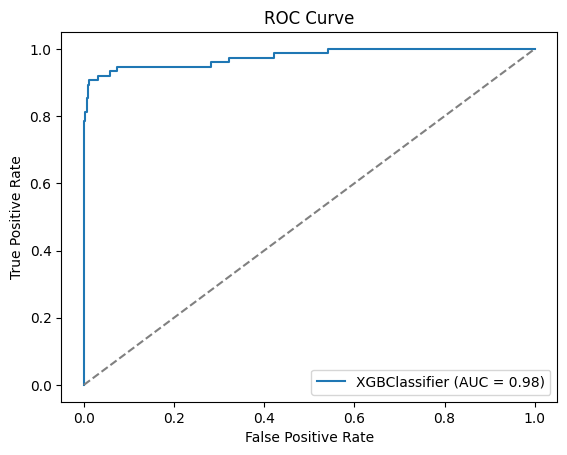

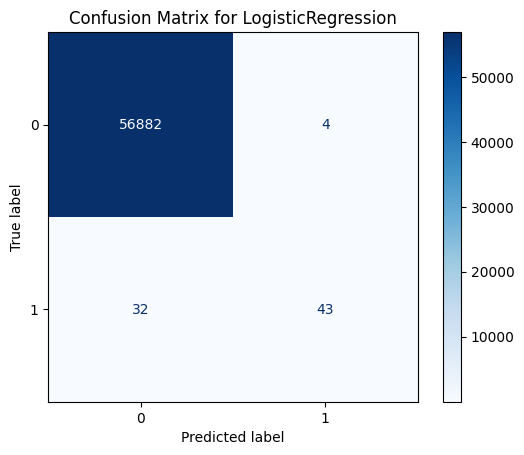

ROC AUC Score: 0.9821228421755792
[LightGBM] [Info] Number of positive: 417, number of negative: 227424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 227841, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001830 -> initscore=-6.301485
[LightGBM] [Info] Start training from score -6.301485

Evaluating LGBMClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56886
           1       0.03      0.09      0.04        75

    accuracy                           0.99     56961
   macro avg       0.51      0.54      0.52     56961
weighted avg       1.00      0.99      1.00     56961



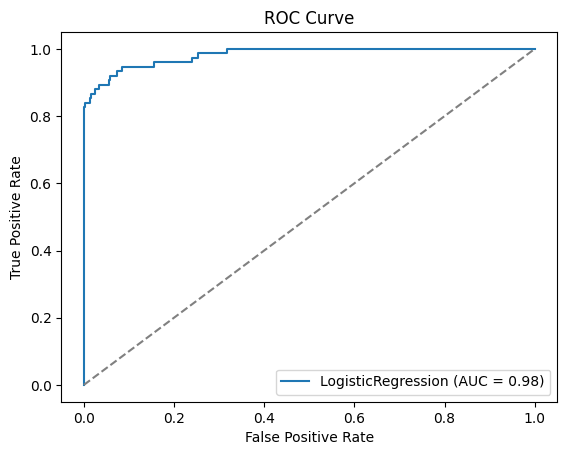

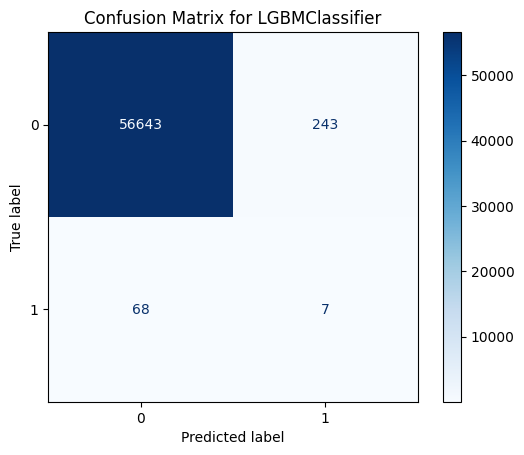

ROC AUC Score: 0.5436088551371749


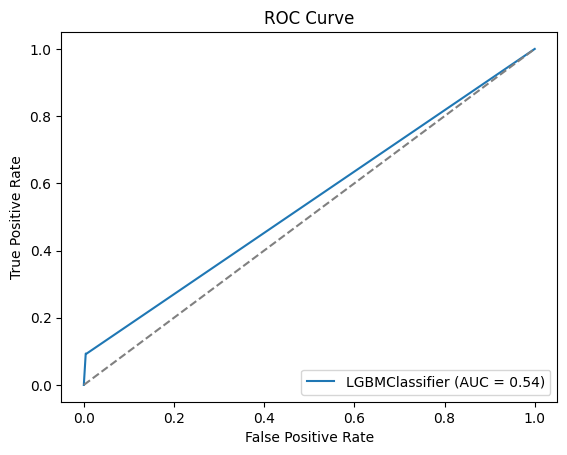

In [ ]:
#Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

#Display the final plot with all ROC curves
plt.show()

From the metrics above, it can also be seen that this combination is not fruitful in creating superior performing models. This suggests that the lag features alone are enough, keeping the models simple yet powerful.

## Temporal Cross Validation

In [9]:
#Function for temporal train-test split

def temporal_split(df):
  split_time = df['Time'].quantile(0.8)
  train_df = df[df['Time'] <= split_time]
  test_df = df[df['Time'] > split_time]
  X_train = train_df.drop(columns=['Class'])
  y_train = train_df['Class']
  X_test = test_df.drop(columns=['Class'])
  y_test = test_df['Class']
  return X_train, y_train, X_test, y_test


#Splits dataset into folds

def split_into_folds(df, num_folds):
    fold_size = len(df) // num_folds
    folds = []
    for fold in range(num_folds):
        start = fold * fold_size
        if(fold == num_folds - 1):
            end = len(df)
        else:
            end = (fold + 1) * fold_size
        fold_df = df.iloc[start:end]
        folds.append(fold_df)
    return folds


#Function to perform Temporal K Fold and train/evaluate model

def run_temporal_kfold(df, model):

  print(f"\nModel: {model.__class__.__name__}")
  num_splits = 5
  tests = []
  predictions = []
  probabilities = []

  df = df.sort_values('Time').reset_index(drop=True)
  folds = split_into_folds(df, num_splits)

  for index, fold in enumerate(folds):

    X_train, y_train, X_test, y_test = temporal_split(fold)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    predictions.extend(y_pred)
    probabilities.extend(y_prob)
    tests.extend(y_test)

    #Confusion Matrix and Classification report
    print(f"\n\nClasses in Fold {index}: {y_test.value_counts().to_dict()}\n")
    print(f"Classification Report for Fold - {index}")
    print(classification_report(y_test, y_pred))


  #Showing final results across all folds
  final_auc = roc_auc_score(tests, probabilities)
  fpr, tpr, _ = roc_curve(tests, probabilities)
  plt.figure()
  plt.plot(fpr, tpr, label=f'Final ROC (AUC = {final_auc:.2f})', color='blue')
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Final ROC Curve - {model.__class__.__name__} (All Folds)')
  plt.legend(loc='lower right')
  plt.grid()
  plt.show()

  cm = confusion_matrix(tests, predictions)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
  cm_display.plot(cmap='Blues')
  plt.title(f"Final Confusion Matrix for {model.__class__.__name__} (all folds)")
  plt.show()

  print(f"\n\nFinal Classification Report")
  print(classification_report(tests, predictions))


### Temporal Cross Validation of Base Models (No Lag Features)

In [ ]:
df

In [4]:
scaler = StandardScaler()

In [5]:
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))


Model: XGBClassifier


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 0: {0: 11377, 1: 15}

Classification Report for Fold - 0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11377
           1       1.00      0.67      0.80        15

    accuracy                           1.00     11392
   macro avg       1.00      0.83      0.90     11392
weighted avg       1.00      1.00      1.00     11392



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 1: {0: 11380, 1: 10}

Classification Report for Fold - 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11380
           1       1.00      0.60      0.75        10

    accuracy                           1.00     11390
   macro avg       1.00      0.80      0.87     11390
weighted avg       1.00      1.00      1.00     11390



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 2: {0: 11388, 1: 4}

Classification Report for Fold - 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11388
           1       0.67      1.00      0.80         4

    accuracy                           1.00     11392
   macro avg       0.83      1.00      0.90     11392
weighted avg       1.00      1.00      1.00     11392



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 3: {0: 11378, 1: 14}

Classification Report for Fold - 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11378
           1       1.00      0.71      0.83        14

    accuracy                           1.00     11392
   macro avg       1.00      0.86      0.92     11392
weighted avg       1.00      1.00      1.00     11392



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 4: {0: 11383, 1: 10}

Classification Report for Fold - 4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11383
           1       0.60      0.60      0.60        10

    accuracy                           1.00     11393
   macro avg       0.80      0.80      0.80     11393
weighted avg       1.00      1.00      1.00     11393



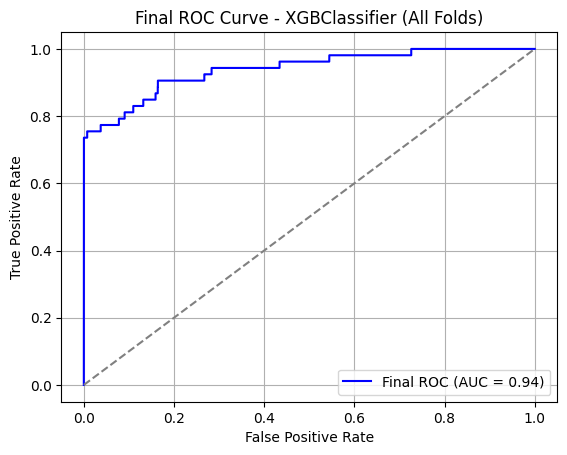

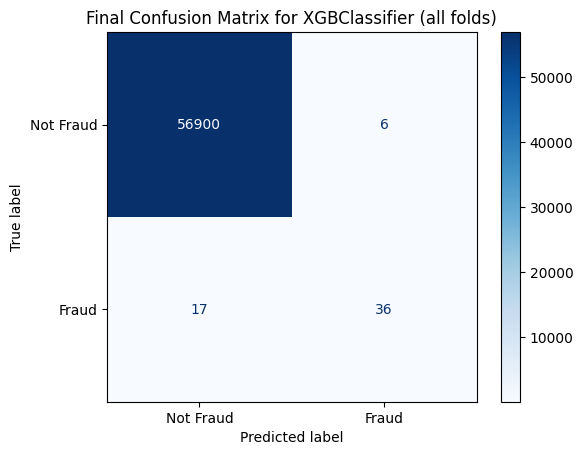



Final Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56906
           1       0.86      0.68      0.76        53

    accuracy                           1.00     56959
   macro avg       0.93      0.84      0.88     56959
weighted avg       1.00      1.00      1.00     56959


Model: LogisticRegression


Classes in Fold 0: {0: 11377, 1: 15}

Classification Report for Fold - 0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11377
           1       1.00      0.13      0.24        15

    accuracy                           1.00     11392
   macro avg       1.00      0.57      0.62     11392
weighted avg       1.00      1.00      1.00     11392



Classes in Fold 1: {0: 11380, 1: 10}

Classification Report for Fold - 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11380
           1       1.00      0

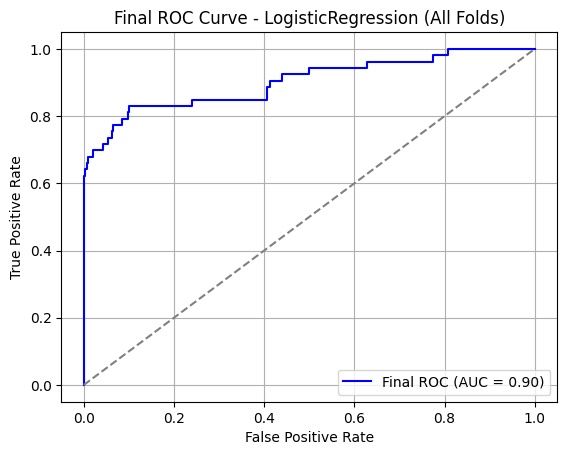

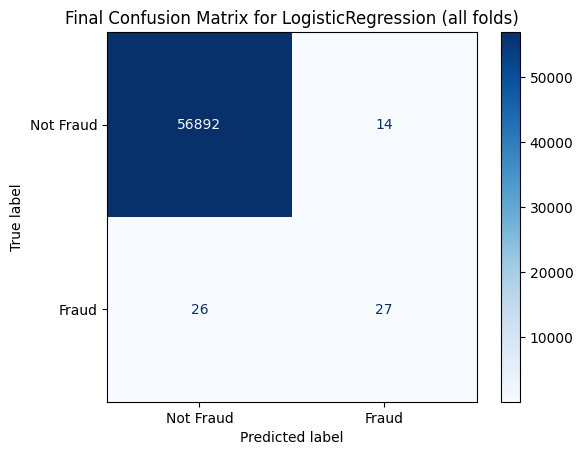



Final Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56906
           1       0.66      0.51      0.57        53

    accuracy                           1.00     56959
   macro avg       0.83      0.75      0.79     56959
weighted avg       1.00      1.00      1.00     56959


Model: LGBMClassifier
[LightGBM] [Info] Number of positive: 142, number of negative: 45427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 45569, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003116 -> initscore=-5.768035
[LightGBM] [Info] Start training from score -5.768035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

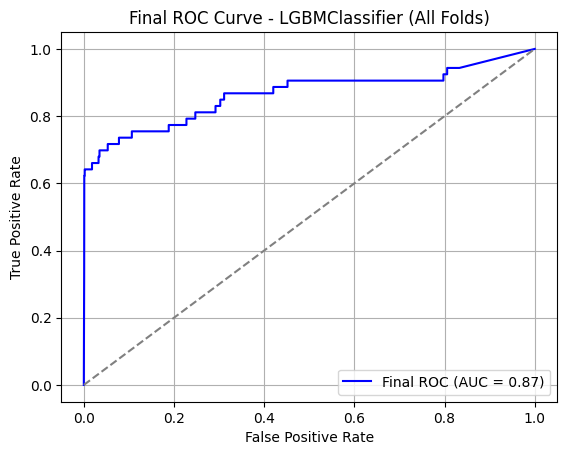

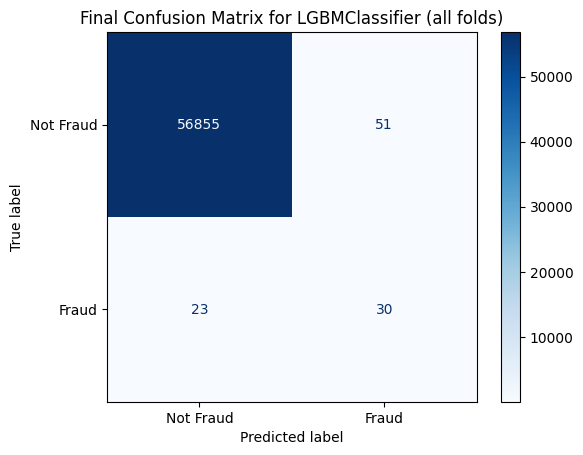



Final Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56906
           1       0.37      0.57      0.45        53

    accuracy                           1.00     56959
   macro avg       0.68      0.78      0.72     56959
weighted avg       1.00      1.00      1.00     56959



In [10]:
for model in models:
    run_temporal_kfold(df, model)

### Temporal Cross-Validation of Models with Lag Features

In [ ]:
df_with_lag_features['Amount'] = scaler.fit_transform(df_with_lag_features['Amount'].values.reshape(-1, 1))
df_with_lag_features['Time'] = scaler.fit_transform(df_with_lag_features['Time'].values.reshape(-1, 1))


Model: XGBClassifier


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:32:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 0: {0: 11374, 1: 15}

Classification Report for Fold - 0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11374
           1       1.00      0.47      0.64        15

    accuracy                           1.00     11389
   macro avg       1.00      0.73      0.82     11389
weighted avg       1.00      1.00      1.00     11389



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:32:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 1: {0: 11381, 1: 10}

Classification Report for Fold - 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11381
           1       1.00      0.60      0.75        10

    accuracy                           1.00     11391
   macro avg       1.00      0.80      0.87     11391
weighted avg       1.00      1.00      1.00     11391



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:32:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 2: {0: 11388, 1: 4}

Classification Report for Fold - 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11388
           1       0.60      0.75      0.67         4

    accuracy                           1.00     11392
   macro avg       0.80      0.87      0.83     11392
weighted avg       1.00      1.00      1.00     11392



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:32:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 3: {0: 11377, 1: 14}

Classification Report for Fold - 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11377
           1       1.00      0.71      0.83        14

    accuracy                           1.00     11391
   macro avg       1.00      0.86      0.92     11391
weighted avg       1.00      1.00      1.00     11391



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:32:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




Classes in Fold 4: {0: 11383, 1: 10}

Classification Report for Fold - 4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11383
           1       0.67      0.60      0.63        10

    accuracy                           1.00     11393
   macro avg       0.83      0.80      0.82     11393
weighted avg       1.00      1.00      1.00     11393



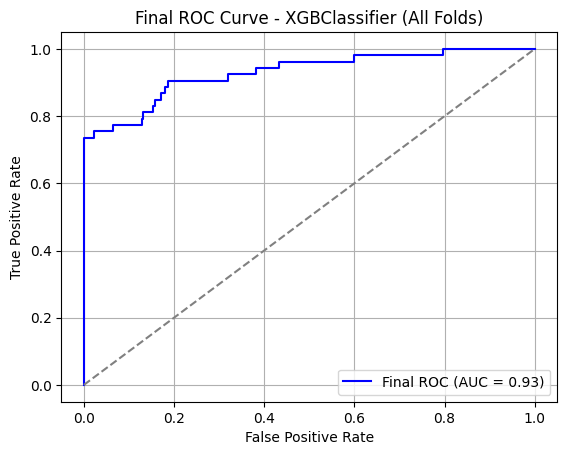

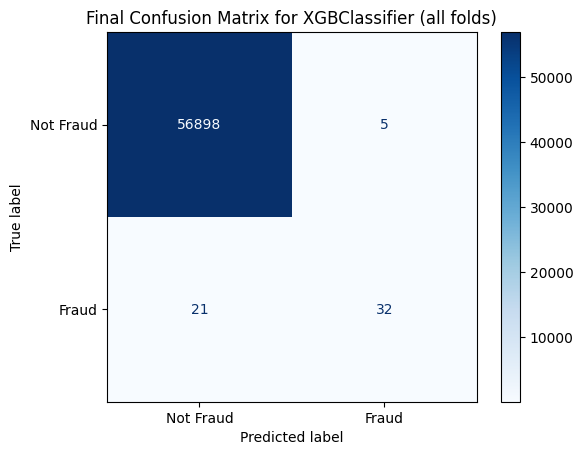



Final Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56903
           1       0.86      0.60      0.71        53

    accuracy                           1.00     56956
   macro avg       0.93      0.80      0.86     56956
weighted avg       1.00      1.00      1.00     56956


Model: LogisticRegression


Classes in Fold 0: {0: 11374, 1: 15}

Classification Report for Fold - 0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11374
           1       1.00      0.13      0.24        15

    accuracy                           1.00     11389
   macro avg       1.00      0.57      0.62     11389
weighted avg       1.00      1.00      1.00     11389



Classes in Fold 1: {0: 11381, 1: 10}

Classification Report for Fold - 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11381
           1       1.00      0

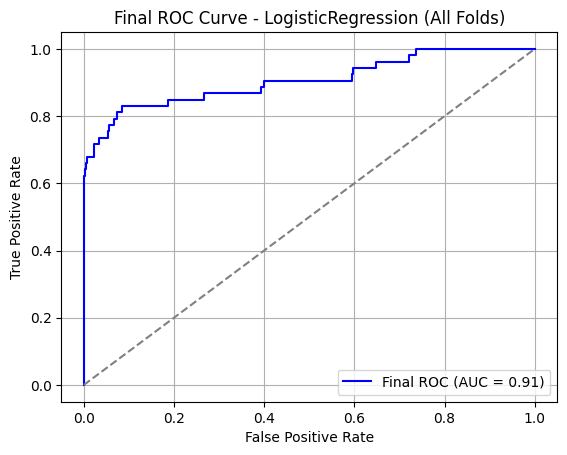

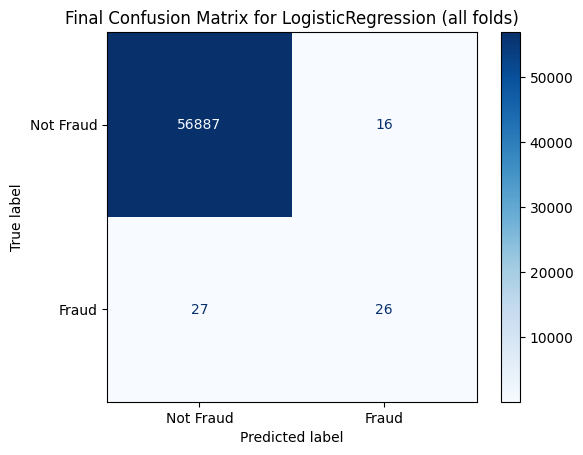



Final Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56903
           1       0.62      0.49      0.55        53

    accuracy                           1.00     56956
   macro avg       0.81      0.75      0.77     56956
weighted avg       1.00      1.00      1.00     56956


Model: LGBMClassifier
[LightGBM] [Info] Number of positive: 142, number of negative: 45429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 45571, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003116 -> initscore=-5.768079
[LightGBM] [Info] Start training from score -5.768079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

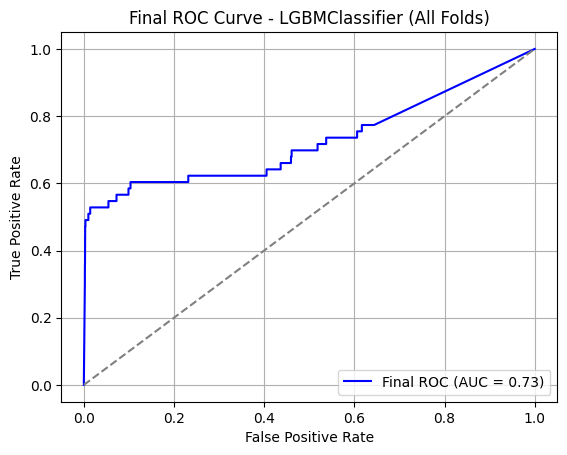

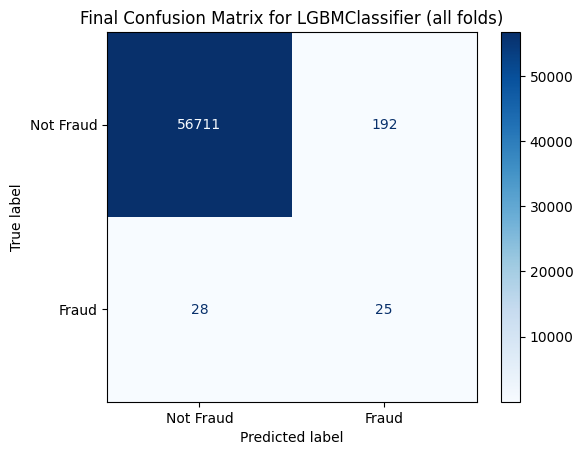



Final Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56903
           1       0.12      0.47      0.19        53

    accuracy                           1.00     56956
   macro avg       0.56      0.73      0.59     56956
weighted avg       1.00      1.00      1.00     56956



In [ ]:
for model in models:
    run_temporal_kfold(df_with_lag_features, model)

It can generally be seen that that there is an increase in performance across the folds when the lag features are added. XGBoost and Logistic Regression are the best performing models, with XGBoost outperforming Logistic Regression across the folds.